In [2]:
print('This notebook was prepared using:')

import os
import sys
print('python version %s' % sys.version)

import numpy as np
print('numpy version %s' % np.__version__)

import pandas as pd
print('pandas version %s' % pd.__version__)

import math
from math import isnan

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
print('matplotlib version %s' % matplotlib.__version__)

import re
import sys
import argparse
import scipy as sp
import random

from scipy import integrate
import scipy.interpolate as sp_interpolate
import statistics

from dataclasses import dataclass
import time as time_module

import simulation as sim
import importlib

# GitHub directories
HIV_DIR = 'data/HIV'
MPL_DIR = 'src/MPL'
SIM_DIR = 'data/simulation'
FIG_DIR = 'figures'

This notebook was prepared using:
python version 3.10.9 | packaged by conda-forge | (main, Feb  2 2023, 20:26:08) [Clang 14.0.6 ]
numpy version 1.24.2
pandas version 1.5.3
matplotlib version 3.7.1


In [8]:
def get_gamma1():
    # individual site: gamma_1s, escape group: gamma_1e
    gamma_1   = np.ones(x_length)*gamma_1s
    for n in range(ne):
        gamma_1[x_length-ne+n] = gamma_1e
    
    return gamma_1

x_length = 10
gamma_1s = 1
gamma_1e = 2
ne = 2
print(get_gamma1())

[1. 1. 1. 1. 1. 1. 1. 1. 2. 2.]


In [106]:
############################################################################
################################# function #################################   
# calculate recombination flux term at time t
def get_rec_flux_at_t(r_rates, x_trait, p_mut_k, trait_dis):

    fluxIn  = 0
    fluxOut = 0

    for nn in range(len(escape_group[n_index])-1):
        fluxIn  += trait_dis[n_index][nn] * (1 - x_trait) *p_mut_k[nn][0]
        fluxOut += trait_dis[n_index][nn] * p_mut_k[nn][1]*p_mut_k[nn][2]
    
    flux = r_rates * (fluxIn - fluxOut)

    return flux

# calculate diffusion matrix C at time t
def diffusion_matrix_at_t(x,xx):
    x_length = len(x)
    C = np.zeros([x_length,x_length])
    for i in range(x_length):
        C[i,i] = x[i] - x[i] * x[i]
        for j in range(int(i+1) ,x_length):
            C[i,j] = xx[i,j] - x[i] * x[j]
            C[j,i] = xx[i,j] - x[i] * x[j]
    return C

# calculate mutation flux term at sampled time
def cal_mut_flux(x,ex,muVec):
    flux = np.zeros((len(x),x_length))
    for t in range(len(x)):
        for i in range(seq_length):
            for a in range(q):
                index = seq_index[i]
                if muVec[index][a] != -1:
                    aa = np.where(poly_index == int(muVec[index][a]))[0]
                    for b in range(q):
                        if b != a:
                            if muVec[index][b] != -1:
                                bb = np.where(poly_index == int(muVec[index][b]))[0]
                                flux[t,aa] +=  muMatrix[b][a] * x[t,bb] - muMatrix[a][b] * x[t,aa]
                            else:
                                flux[t,aa] += -muMatrix[a][b] * x[t,aa]

        for nn in range(len(escape_group[n_index])):
            for a in range(q):
                WT = escape_TF[n_index][nn]

                if a not in WT:
                    for b in WT:
                        flux[t, -1] += muMatrix[b][a] * (1 - x[t,-1]) - muMatrix[a][b] * ex[t,nn,a]

    return flux

# calculate the frequency change at all times
def cal_delta_x(single_freq,times):

    delta_x  = np.zeros((len(single_freq),x_length))   # difference between the frequency at time t and time t-1s
    # calculate manually
    for t in range(len(single_freq)-1):
        delta_x[t] = (single_freq[t+1] - single_freq[t])/(times[t+1]-times[t])

    # dt for the last time point, make sure the expected x[t+1] is less than 1
    for ii in range(x_length):
        if single_freq[-1,ii] == 1:
            delta_x[-1,ii] = 0
        else:
            delta_x[-1,ii] = delta_x[-2,ii]

    return delta_x

# regularization value gamma_1 and gamma_2
# gamma_1: time-independent, gamma_2: time-dependent
def get_gamma1(last_time):
    # individual site: gamma_1s, escape group: gamma_1p
    gamma_1s = np.round(gamma_1/last_time,3) # constant MPL gamma value / max time
    gamma_1p = gamma_1s/10
    
    gamma1   = np.ones(x_length)*gamma_1s
    for n in range(ne):
        gamma1[x_length-ne+n] = gamma_1p
    
    return gamma1

def get_gamma2(last_time, beta):
    # Use a time-varying gamma_prime, gamma_2tv is the middle value, 
    # boundary value is 4 times larger, decrese/increase exponentially within 10% generation.
    gamma_t = np.ones(len(ExTimes))
    tv_range = max(int(round(last_time*0.1/10)*10),1)
    alpha  = np.log(beta) / tv_range
    for ti, t in enumerate(ExTimes): # loop over all time points, ti: index, t: time
        if t <= 0:
            gamma_t[ti] = beta
        elif t >= last_time:
            gamma_t[ti] = beta
        elif 0 < t and t <= tv_range:
            gamma_t[ti] = beta * np.exp(-alpha * t)
        elif last_time - tv_range < t and t <= last_time:
            gamma_t[ti] = 1 * np.exp(alpha * (t - last_time + tv_range))
        else:
            gamma_t[ti] = 1
    
    gamma2 = np.ones((x_length,len(ExTimes)))* gamma_2c
    gamma2[-1] = gamma_t * gamma_2tv

    return gamma2.T

def insert_time(arr, allowed_gaps=(7, 8, 9, 10, 11, 12, 13)):
    """
    Insert values into an array, ensuring the difference between adjacent values 
    is within the allowed_gaps range as evenly distributed as possible.
    """
    result = []

    for i in range(len(arr) - 1):
        result.append(arr[i])  # add current value
        diff = arr[i+1] - arr[i]
        
        if diff < max(allowed_gaps):
            continue

        while diff > max(allowed_gaps):
            # choose the gap that is closest to 10
            if diff % 10 == 0:
                step = diff/10
            else:
                step = (diff // 10) + 1
            gap = min(allowed_gaps, key=lambda x: abs(x - diff / step))
            next_value = result[-1] + gap
            result.append(next_value)
            diff = arr[i+1] - next_value  # update the remaining difference
        
        # check if the last gap is in the allowed_gaps
        if diff not in allowed_gaps:
            print(f"Warning: the gap between {result[-1]} and {arr[i+1]} is not in the allowed_gaps range.")
        
    # Add the last value
    if result[-1] != arr[-1]:
        result.append(arr[-1])

    return np.array(result)


def get_ExTimes(times):
    t_extend = int(round(times[-1]*0.5/10)*10)
    if t_extend <= 10:
        time_step = 5
    elif t_extend <= 30:
        time_step = 10
    elif t_extend <= 100:
        time_step = 20
    elif t_extend <= 300:
        time_step = 50
    else:
        time_step = 100

    etleft  = np.arange(-t_extend, 0, time_step)
    etright = np.arange(times[-1]+time_step,times[-1]+t_extend,time_step)
    if times[-1]+t_extend - etright[-1]  < time_step/2:
        etright[-1] = times[-1]+t_extend
    else:
        etright = np.append(etright, times[-1]+t_extend)
    ExTimes = np.concatenate((etleft, times, etright))
    
    return ExTimes

def get_cut_index(epitope):
    df_trait = pd.read_csv('%s/constant/epitopes/escape_group-%s.csv' %(HIV_DIR,tag), comment='#', memory_map=True)
    # get all binary traits for one tag
    df_rows = df_trait[df_trait['epitope'].notna()]
    unique_traits = df_rows['epitope'].unique()
    
    n_index = np.where(unique_traits == epitope)[0][0]
    poly_sites = escape_group[n_index]

    selected_rows = muVec[poly_sites[0]:poly_sites[-1], :]
    poly_index = selected_rows[selected_rows != -1]

    return poly_sites,poly_index,n_index

In [174]:
#!/usr/bin/env python
# coding: utf-8

import try_HIV as try_HIV
import importlib
importlib.reload(try_HIV)

## nucleotide parameter
NUC = ['-', 'A', 'C', 'G', 'T']
q = len(NUC)

gamma_2tv_all = [50, 200]
begin_all     = [True, False]
end_all       = [True, False]
xdotpre       = True

tag        = '700010077-3'  # '700010040-3'  # '703010256-3'
epitope    = 'QF-RNKTIVF'   # 'AIRKAILGR'    # 'RNRSIRLVN'

sc_all_cases = []
epi_name   = epitope[0] + epitope[-1] + str(len(epitope))

for gamma_2tv in gamma_2tv_all:
    for begin in begin_all:
        for end in end_all:  
            # x,desired_sc_sample,sample_times = try_HIV.infer_epitope(tag,epitope,gamma_2tv,begin,end,xdotpre)
            result = try_HIV.infer_epitope(tag,epitope,gamma_2tv,begin,end,xdotpre)
            sc_all_cases.append(result[1])

x = result[0]
sample_times = result[-1]

In [181]:
#!/usr/bin/env python
# coding: utf-8

import try_HIV as try_HIV
import importlib
importlib.reload(try_HIV)

## nucleotide parameter
NUC = ['-', 'A', 'C', 'G', 'T']
q = len(NUC)

tag        = '700010607-3'
epitope    = 'KRREILDLWVY'

result = try_HIV.infer_epitope(tag,epitope,50,True,True,True)

[-10.  -5.   0.   9.  14.  21.  26.  31.]
[-10.  -5.   0.   9.  14.  21.  26.  31.]
[-7.5 -2.5  4.5 11.5 17.5 23.5 28.5]
[-10.  -5.   0.   9.  14.  21.  26.  31.]
[-10.  -5.   0.   9.  14.  21.  26.  31.]
[-10.  -5.   0.   9.  14.  21.  26.  31.]
[-10.  -5.   0.   9.  14.  21.  26.  31.]
[-10.  -5.   0.   9.  14.  21.  26.  31.]
[-10.  -5.   0.   9.  14.  21.  26.  31.]
[-10.  -5.   0.   9.  14.  21.  26.  31.]
[-10.  -5.   0.   9.  14.  21.  26.  31.]
[-10.  -5.   0.   9.  14.  21.  26.  31.]
[-10.  -5.   0.   9.  14.  21.  26.  31.]
[-10.  -5.   0.   9.  14.  21.  26.  31.]
[-10.  -5.   0.   9.  14.  21.  26.  31.]
[-10.  -5.   0.   9.  14.  21.  26.  31.]
[-10.  -5.   0.   9.  14.  21.  26.  31.]
[-10.  -5.   0.   9.  14.  21.  26.  31.]
[-10.  -5.   0.   9.  14.  21.  26.  31.]
[-10.  -5.   0.   9.  14.  21.  26.  31.]
[-10.  -5.   0.   9.  14.  21.  26.  31.]
[-7.5 -2.5  4.5 11.5 17.5 23.5 28.5]
[-7.5 -2.5  4.5 11.5 17.5 23.5 28.5]
[-7.5 -2.5  4.5 11.5 17.5 23.5 28.5]
[-7.5 -2.5  

In [74]:
infer_tags =['705010185-5','703010256-3','700010040-3','704010042-3','705010162-3']
omegas = [1,10]

f = open("src/HIV-guassian.sh",'w')

f.write('#!/bin/bash\n')
f.write('cd ..\n')

# for i in range(len(infer_tags)):
#     tag = infer_tags[i]
#     f.write('python try_HIV.py -tag %s -output output-new --raw\n'%(tag))
    
for i in range(len(infer_tags)):
    tag = infer_tags[i]
    for omega in omegas:
        f.write('python new_infer.py -tag %s -output output-new -o %d'%(tag,omega))
        f.write(' || echo "CH%s failed, continuing with next script..." \n'%tag[-5:])
        
f.write('echo "All scripts have been attempted."')
f.close()

In [75]:
import figures as fig
importlib.reload(fig)

pdata = {                    
    'tag':       '700010058-3',
    'HIV_DIR':   'data/HIV',
    'FIG_DIR':   'figures/HIV-try',
    'dir_names': ['output/old','output/new','output-new/mul'], # input file name
    'markers':   ['o','*','^'],
    'name':      'multiple',
    'xtick':     [],
    'xminortick':[],
    'ytick':     [],
    'yminortick':[],
    'savepdf':   True,
        }
infer_tags=['700010040-3','700010040-5','700010058-3','700010058-5','700010077-3','700010077-5',
            '700010470-3','700010470-5','700010607-3','703010131-3','703010131-5','703010159-3',
            '703010256-3','703010256-5','704010042-3','704010042-5','705010162-3','705010162-5',
            '705010185-5','705010198-3','706010164-3','706010164-5']


for tag in infer_tags:
    pdata['tag'] = tag
    fig.plot_epitopes_compare(**pdata)
    plt.close()

CH077-5 has no binary trait
CH162-5 has no binary trait
CH164-5 has no binary trait


In [4]:
import figures as fig
importlib.reload(fig)

pdata = {                    
    'tag':       '700010058-3',
    'HIV_DIR':   'data/HIV',
    'FIG_DIR':   'figures/HIV-try',
    'dir_names': ['output/old','output-new/10'], # input file name
    'markers':   ['o','p'],
    'name':      'gamma',
    'xtick':     [],
    'xminortick':[],
    'ytick':     [],
    'yminortick':[],
    'savepdf':   True,
        }

infer_tags =['700010077-3','705010185-5','703010256-3','700010040-3','704010042-3','705010162-3']

for tag in infer_tags:
    pdata['tag'] = tag
    fig.plot_epitopes_compare(**pdata)
    plt.close()
    

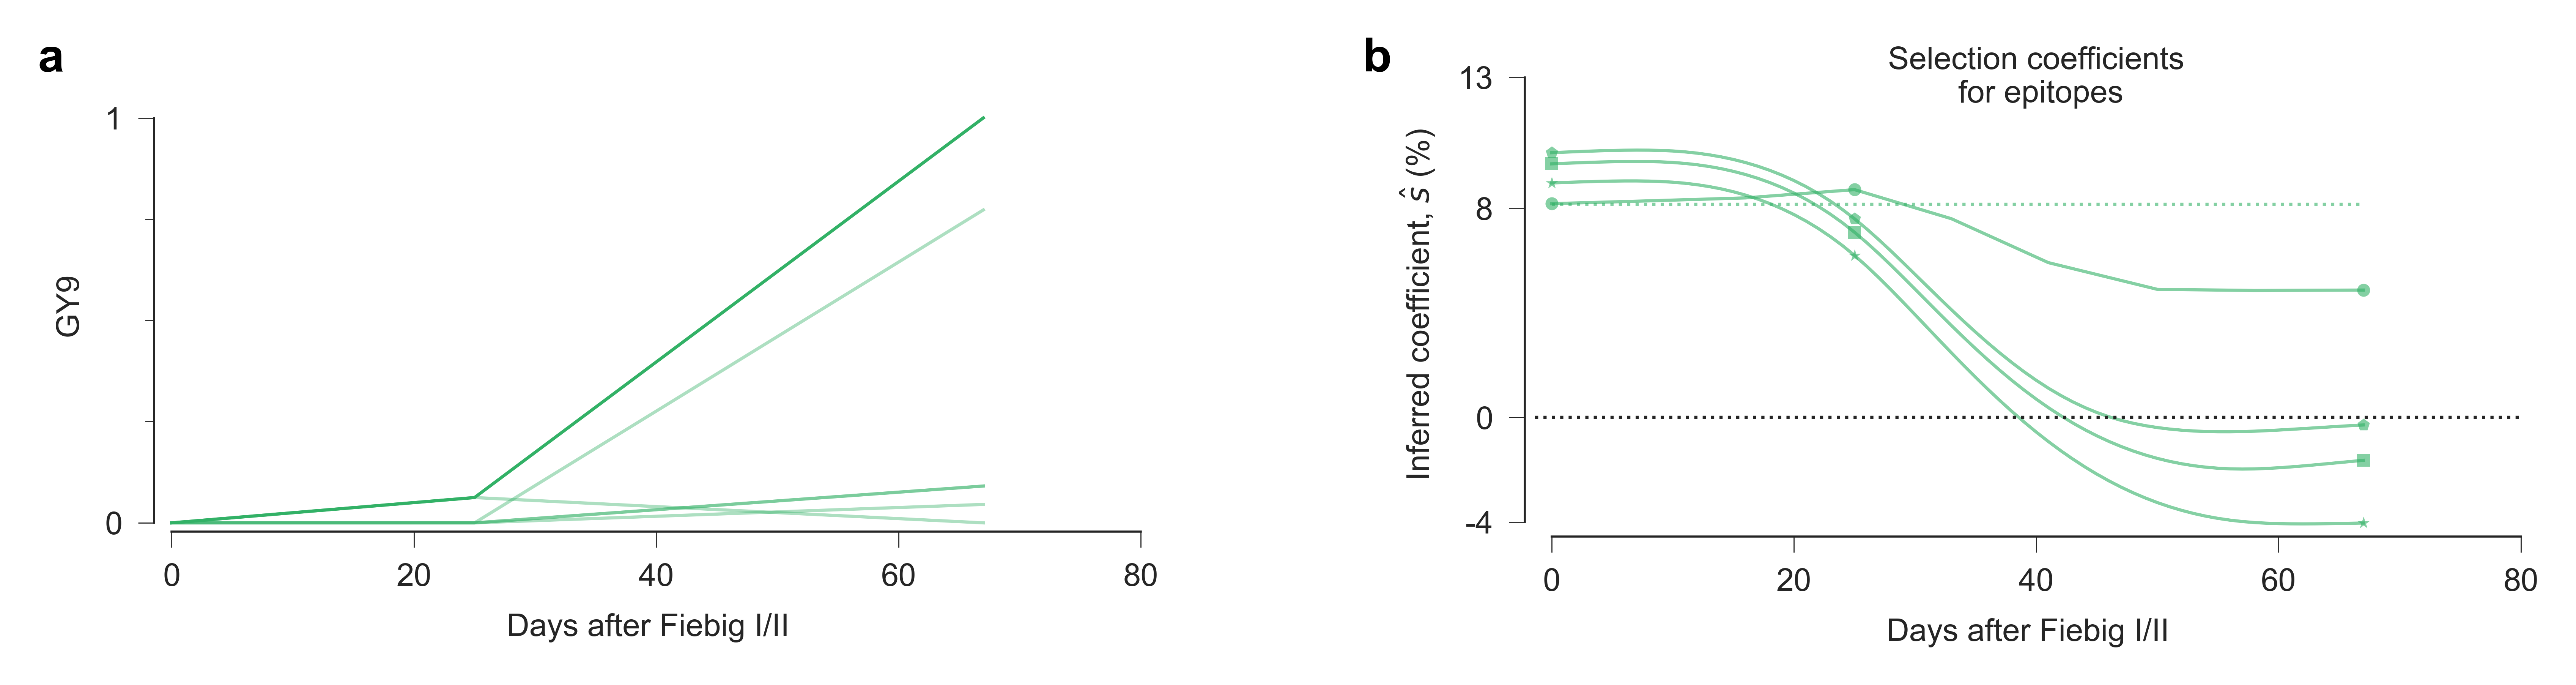

In [88]:
import figures as fig
importlib.reload(fig)

pdata = {                    
    'tag':       '705010185-5',
    'HIV_DIR':   'data/HIV',
    'FIG_DIR':   'figures/HIV-try',
    # 'dir_names': ['output/old','output/new','output-new/1','output-new/10','output-new/100'], # input file name
    # 'markers':   ['o','*','s','p','h'],
    'dir_names': ['output/old','output/new','output-new/1','output-new/10'], # input file name
    'markers':   ['o','*','s','p'],
    'name':      'gamma',
    'xtick':     [],
    'xminortick':[],
    'ytick':     [],
    'yminortick':[],
    'savepdf':   True,
        }

fig.plot_epitopes_compare(**pdata)

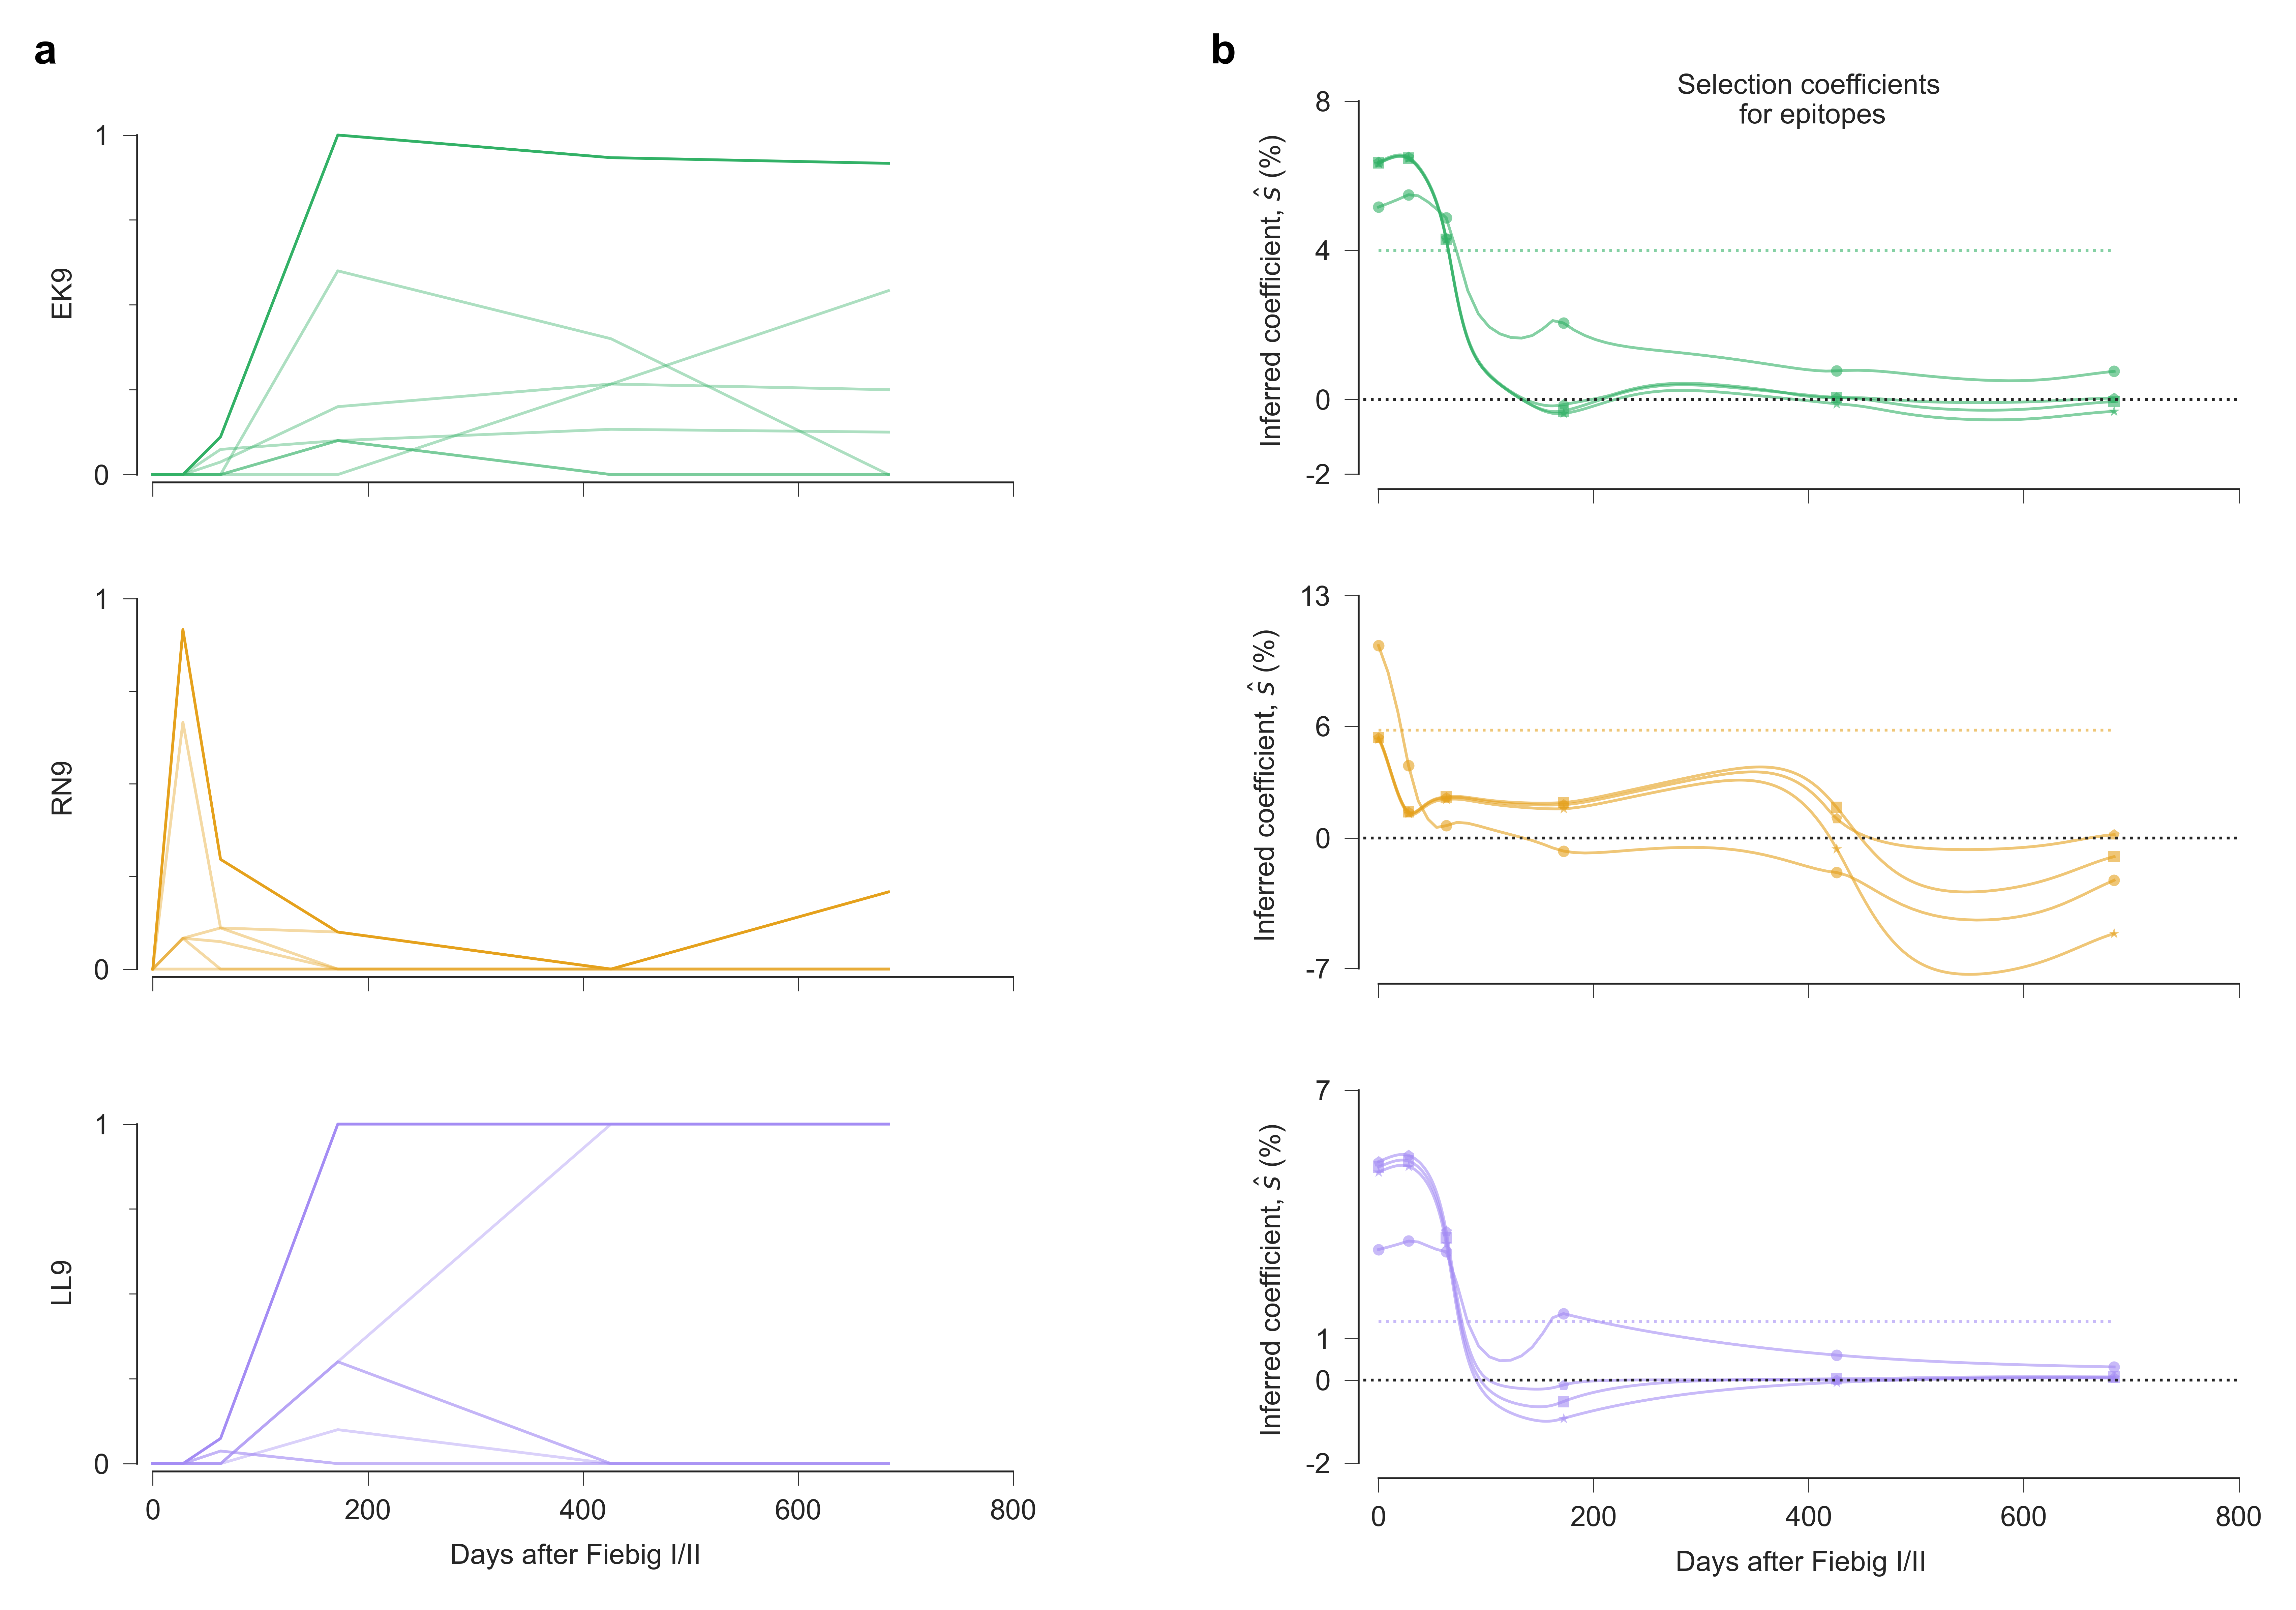

In [86]:
import figures as fig
importlib.reload(fig)

pdata = {                    
    'tag':       '703010256-3',
    'HIV_DIR':   'data/HIV',
    'FIG_DIR':   'figures/HIV-try',
    # 'dir_names': ['output/old','output/new','output-new/1','output-new/10','output-new/100'], # input file name
    # 'markers':   ['o','*','s','p','h'],
    'dir_names': ['output/old','output/new','output-new/1','output-new/10'], # input file name
    'markers':   ['o','*','s','p'],
    'name':      'gamma',
    'xtick':     [],
    'xminortick':[],
    'ytick':     [],
    'yminortick':[],
    'savepdf':   True,
        }

fig.plot_epitopes_compare(**pdata)

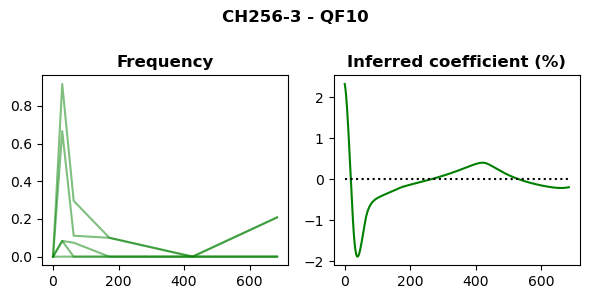

In [462]:
importlib.reload(try_HIV)

## nucleotide parameter
NUC = ['-', 'A', 'C', 'G', 'T']
q = len(NUC)

# tag        = '700010077-3' 
# epitope    = 'QF-RNKTIVF'  

tag        = '703010256-3'
epitope    = 'RNRSIRLVN'

result = try_HIV.infer_epitope(tag,epitope,50)

x = result[0].T
sc_all = result[1]
sample_times = result[-1]

time_sample       = np.linspace(sample_times[0], sample_times[-1], int(sample_times[-1]-sample_times[0]+1))

fig, axes = plt.subplots(1, 2, figsize=(6,3))

for i in range(len(x)):
    if x[i][0]<= x[-1][0]:
        axes[0].plot(sample_times, x[i], alpha=0.5, color='g')
axes[0].set_title(f'Frequency', fontsize=12, fontweight='bold')

axes[1].plot(time_sample, sc_all[-1]*100, color='g')
axes[1].plot(sample_times, np.zeros(len(sample_times)), color='k',ls=':')
axes[1].set_title(f'Inferred coefficient (%)', fontsize=12, fontweight='bold')

plt.suptitle(f'CH{tag[-5:]} - {epi_name}', fontsize=12, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

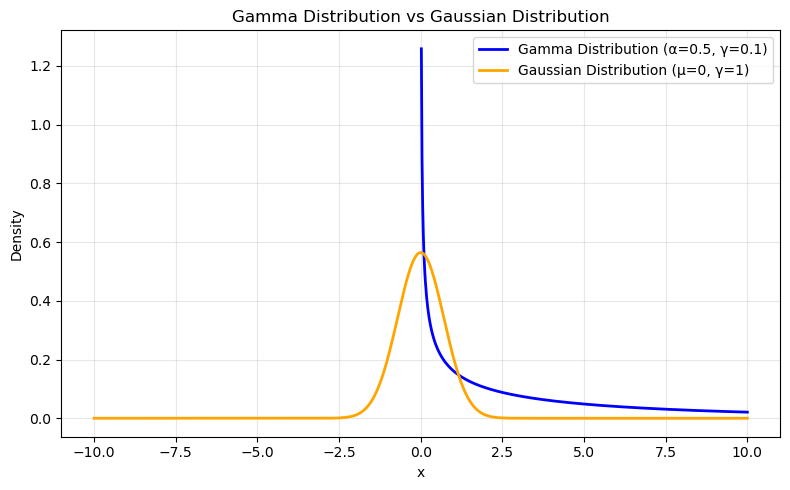

In [460]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma, norm

# Gamma distribution
x0 = np.linspace(0, 10, 500)
shape_gamma = 0.5
scale_gamma = 10
y_gamma = gamma.pdf(x0, a=shape_gamma, scale=scale_gamma)

# Guassian distribution
x1 = np.linspace(-10, 10, 500)
mean_gauss = 0
stddev_gauss = 0.5**(0.5)
y_gauss = norm.pdf(x1, loc=mean_gauss, scale=stddev_gauss)

plt.figure(figsize=(8, 5))

gamma_gamma = 1/scale_gamma
plt.plot(x0, y_gamma, label=f'Gamma Distribution (α={shape_gamma}, γ={gamma_gamma})', color='blue', lw=2)

gamma_gaussian = 1/(2*stddev_gauss*stddev_gauss)
plt.plot(x1, y_gauss, label=f'Gaussian Distribution (μ={mean_gauss}, γ=1)', color='orange', lw=2)

plt.title('Gamma Distribution vs Gaussian Distribution')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

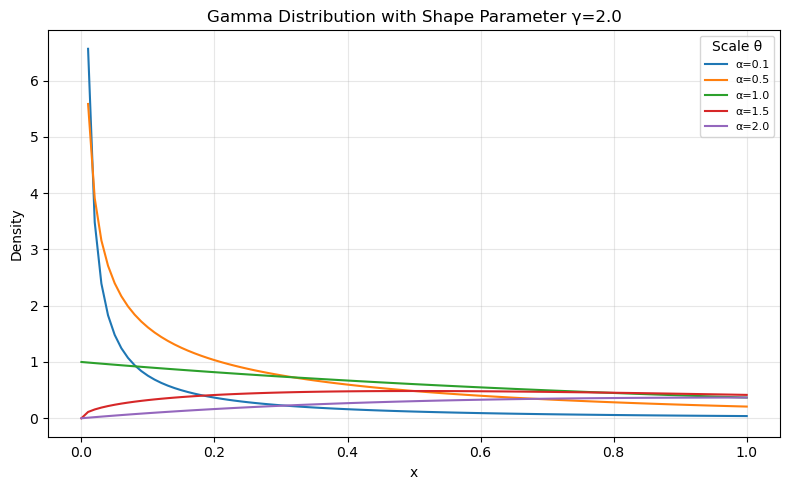

In [325]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma

x = np.linspace(0, 1, 101)

shape_values = [0.1, 0.5, 1.0, 1.5, 2.0]
scale_values = 1

plt.figure(figsize=(8, 5))

for scale_alpha in shape_values:
    y_gamma = gamma.pdf(x, a=scale_alpha, scale=scale_values)
    plt.plot(x, y_gamma, label=f'α={scale_alpha:.1f}')

# 添加图例和标签
plt.title(f'Gamma Distribution with Shape Parameter γ={1/shape_gamma}')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend(loc='upper right', fontsize=8, title="Scale θ")
plt.grid(alpha=0.3)

# 显示图像
plt.tight_layout()
plt.show()

In [417]:
### parameter
importlib.reload(sim)

generations = 100
fn = np.zeros(generations+1)

for t in range(len(fn)):
    fn[t] = 0.06 - 0.06/generations * t

trait_dir = 'trait'
pdata = {  
    'NUC':           ['A', 'T'],      # all possible alleles
    'dir':           trait_dir,       # directory of this simulation
    'xfile':         '0',             # output file name
    'seq_length':    10,              # sequence length
    'pop_size':      1000,            # population size
    'generations':   generations,     # number of total generations
    'totalT':        generations,     # generations used to infer
    'mut_rate':      1e-3,            # mutation rate
    'rec_rate':      1e-3,            # recombination rate
    'inital_state':  1,               # number of initial sub-population
    'n_ben':         3,               # number of beneficial mutations
    'n_del':         3,               # number of deleterious mutations
    'bene':          [0,1,2],       # constant beneficial mutations sites
    'dele':          [7,8,9],   # constant deleterious mutations sites
    's_ben':         0.02,            # selection coefficient of beneficial mutations
    's_del':         -0.02,           # selection coefficient of deleterious mutations
    'fn':            fn,              # time-varying selection coefficient for binary trait
    'escape_group':  [[2,5,7]],    # escape sites
    'escape_TF':     [[0,0,0]],       # wild type sequences for escape sites
    'trait_dis':     [[3,2]],         # distance between trait sites
    'x_thresh':      0.005,           # threshold for single allele frequency
    'gamma_s':       1,               # regularization - selection coefficients - constant part
    'gamma_2c':      100000,          # regularization - the time derivative of the selection coefficients
    'gamma_2tv':     50,             # regularization - the time derivative of the selection coefficients
    'theta':         0.5,             # magnification of extended time at the ends
    'beta':          4,               # magnification of extended gamma_2 at the ends
    'bc_n':          True,            # True: Neumann boundary condition; False: Dirichlet boundary condition
    }

sim.simulate_trait_gamma(**pdata)

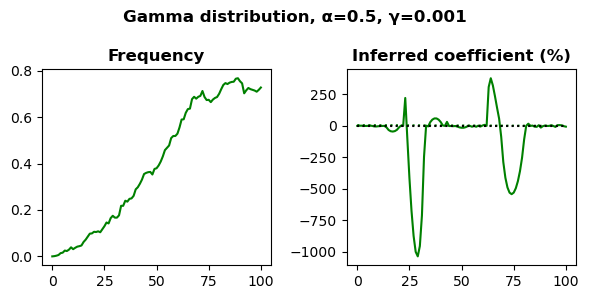

In [433]:
importlib.reload(sim)

gamma_gamma = 0.001
pdata['gamma_p'] = gamma_gamma
x,sc_all = sim.infer_trait_gamma(**pdata)

sample_times = np.linspace(0,generations,generations+1)
time_sample  = np.linspace(sample_times[0], sample_times[-1], int(sample_times[-1]-sample_times[0]+1))

fig, axes = plt.subplots(1, 2, figsize=(6,3))

axes[0].plot(sample_times, x.T[-1], alpha=1.0, color='g')
axes[0].set_title(f'Frequency', fontsize=12, fontweight='bold')

axes[1].plot(sample_times, sc_all[-1]*100, color='g')
axes[1].plot(sample_times, fn*100, color='g',ls=':')
axes[1].plot(sample_times, np.zeros(len(sample_times)), color='k',ls=':')

axes[1].set_title(f'Inferred coefficient (%)', fontsize=12, fontweight='bold')
plt.suptitle(f'Gamma distribution, α=0.5, γ={gamma_gamma}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

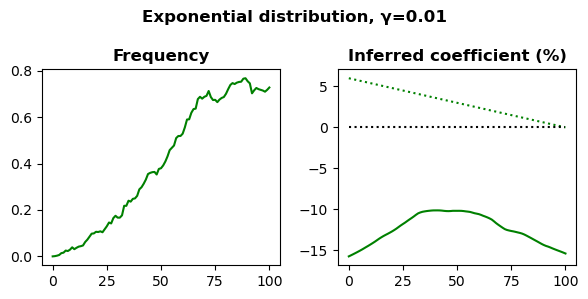

In [432]:
importlib.reload(sim)

gamma_gamma = 0.01
pdata['gamma_p'] = gamma_gamma
x,sc_all = sim.infer_trait_gamma(**pdata)

sample_times = np.linspace(0,generations,generations+1)
time_sample  = np.linspace(sample_times[0], sample_times[-1], int(sample_times[-1]-sample_times[0]+1))

fig, axes = plt.subplots(1, 2, figsize=(6,3))

axes[0].plot(sample_times, x.T[-1], alpha=1.0, color='g')
axes[0].set_title(f'Frequency', fontsize=12, fontweight='bold')

axes[1].plot(sample_times, sc_all[-1]*100, color='g')
axes[1].plot(sample_times, fn*100, color='g',ls=':')
axes[1].plot(sample_times, np.zeros(len(sample_times)), color='k',ls=':')

axes[1].set_title(f'Inferred coefficient (%)', fontsize=12, fontweight='bold')
plt.suptitle(f'Exponential distribution, γ={gamma_gamma}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

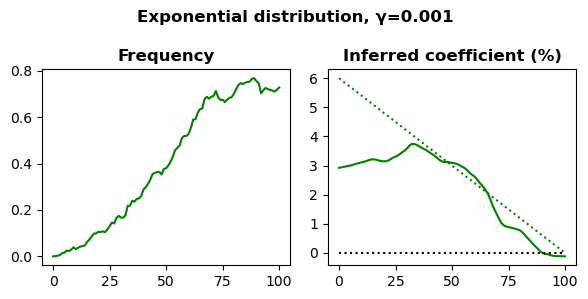

In [430]:
importlib.reload(sim)

gamma_gamma = 0.001
pdata['gamma_p'] = gamma_gamma
x,sc_all = sim.infer_trait_gamma(**pdata)

sample_times = np.linspace(0,generations,generations+1)
time_sample  = np.linspace(sample_times[0], sample_times[-1], int(sample_times[-1]-sample_times[0]+1))

fig, axes = plt.subplots(1, 2, figsize=(6,3))

axes[0].plot(sample_times, x.T[-1], alpha=1.0, color='g')
axes[0].set_title(f'Frequency', fontsize=12, fontweight='bold')

axes[1].plot(sample_times, sc_all[-1]*100, color='g')
axes[1].plot(sample_times, fn*100, color='g',ls=':')
axes[1].plot(sample_times, np.zeros(len(sample_times)), color='k',ls=':')

axes[1].set_title(f'Inferred coefficient (%)', fontsize=12, fontweight='bold')
plt.suptitle(f'Exponential distribution, γ={gamma_gamma}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

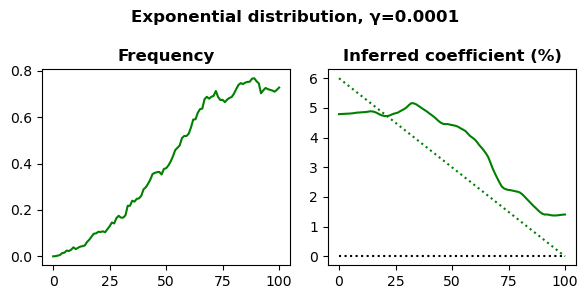

In [431]:
importlib.reload(sim)

gamma_gamma = 0.0001
pdata['gamma_p'] = gamma_gamma
x,sc_all = sim.infer_trait_gamma(**pdata)

sample_times = np.linspace(0,generations,generations+1)
time_sample  = np.linspace(sample_times[0], sample_times[-1], int(sample_times[-1]-sample_times[0]+1))

fig, axes = plt.subplots(1, 2, figsize=(6,3))

axes[0].plot(sample_times, x.T[-1], alpha=1.0, color='g')
axes[0].set_title(f'Frequency', fontsize=12, fontweight='bold')

axes[1].plot(sample_times, sc_all[-1]*100, color='g')
axes[1].plot(sample_times, fn*100, color='g',ls=':')
axes[1].plot(sample_times, np.zeros(len(sample_times)), color='k',ls=':')

axes[1].set_title(f'Inferred coefficient (%)', fontsize=12, fontweight='bold')
plt.suptitle(f'Exponential distribution, γ={gamma_gamma}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

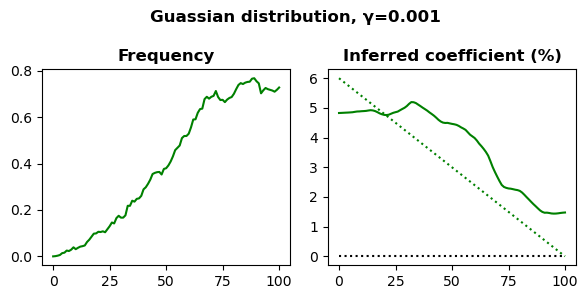

In [446]:
importlib.reload(sim)

x,sc_all = sim.infer_trait_gamma(**pdata)

sample_times = np.linspace(0,generations,generations+1)
time_sample  = np.linspace(sample_times[0], sample_times[-1], int(sample_times[-1]-sample_times[0]+1))

fig, axes = plt.subplots(1, 2, figsize=(6,3))

axes[0].plot(sample_times, x.T[-1], alpha=1.0, color='g')
axes[0].set_title(f'Frequency', fontsize=12, fontweight='bold')

axes[1].plot(sample_times, sc_all[-1]*100, color='g')
axes[1].plot(sample_times, fn*100, color='g',ls=':')
axes[1].plot(sample_times, np.zeros(len(sample_times)), color='k',ls=':')

axes[1].set_title(f'Inferred coefficient (%)', fontsize=12, fontweight='bold')

plt.suptitle(f'Guassian distribution, γ={gamma_gamma}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

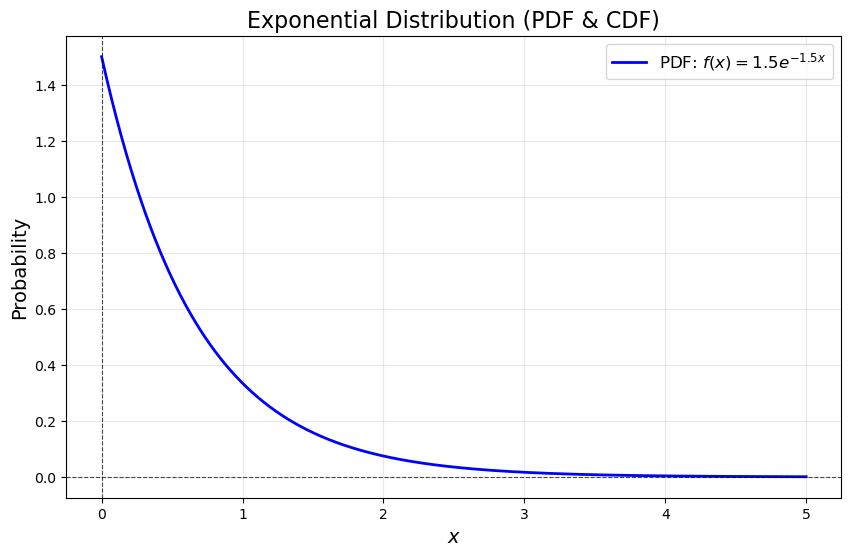

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon

# 设置参数
lambda_param = 1.5  # 指数分布的速率参数 λ (λ > 0)

# 定义x的范围
x = np.linspace(0, 5, 1000)  # x 从 0 到 5 的等间距点

# 计算概率密度函数 (PDF)
pdf = lambda_param * np.exp(-lambda_param * x)

# # 计算累积分布函数 (CDF)
# cdf = 1 - np.exp(-lambda_param * x)

# 绘制 PDF 和 CDF
plt.figure(figsize=(10, 6))

# 绘制 PDF
plt.plot(x, pdf, label=f'PDF: $f(x) = {lambda_param} e^{{-{lambda_param}x}}$', color='blue', lw=2)

# 绘制 CDF
# plt.plot(x, cdf, label=f'CDF: $F(x) = 1 - e^{{-{lambda_param}x}}$', color='orange', lw=2, linestyle='--')

# 图表美化
plt.title("Exponential Distribution (PDF & CDF)", fontsize=16)
plt.xlabel("$x$", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.axhline(0, color="black", linewidth=0.8, linestyle="--", alpha=0.7)
plt.axvline(0, color="black", linewidth=0.8, linestyle="--", alpha=0.7)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)

# 显示图表
plt.show()

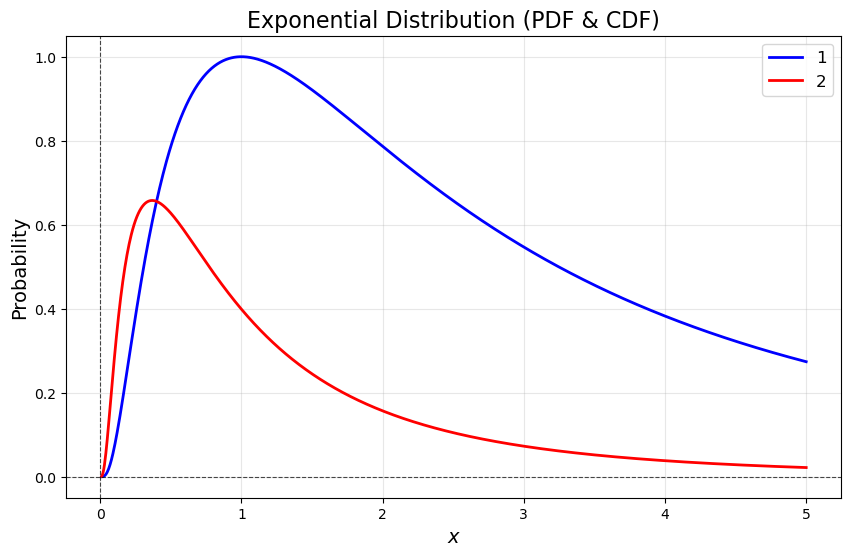

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon

# 设置参数
mean = 0  # 对数均值
sigma = 1  # 对数标准差 (σ > 0)

# 定义 x 的范围
x = np.linspace(0.01, 5, 1000)  # 从 0 开始（略微偏离0）

# 计算概率密度函数 (PDF)
pdf1 = np.exp(- (np.log(x) - mean)** 2/(2*sigma** 2))
pdf2 = (1 / (x * sigma * np.sqrt(2 * np.pi))) * np.exp(-((np.log(x) - mean) ** 2) / (2 * sigma ** 2))

# 绘制 PDF 和 CDF
plt.figure(figsize=(10, 6))

# 绘制 PDF
plt.plot(x, pdf1, label=f'1', color='blue', lw=2)
plt.plot(x, pdf2, label=f'2', color='red', lw=2)


# 图表美化
plt.title("Exponential Distribution (PDF & CDF)", fontsize=16)
plt.xlabel("$x$", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.axhline(0, color="black", linewidth=0.8, linestyle="--", alpha=0.7)
plt.axvline(0, color="black", linewidth=0.8, linestyle="--", alpha=0.7)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)

# 显示图表
plt.show()


In [59]:
(np.log(5))**2

2.5902903939802346

In [60]:
np.log(10)

2.302585092994046

In [5]:
from scipy.interpolate import interp1d
def get_mut_flux_at_t(x,ex,muVec):
    flux = np.zeros(x_length)
    for i in range(seq_length):
        for a in range(q):
            aa = int(muVec[i][a])
            if aa != -1:
                for b in range(q):
                    bb = int(muVec[i][b])
                    if b != a:
                        if bb != -1:
                            flux[aa] +=  muMatrix[b][a] * x[bb] - muMatrix[a][b] * x[aa]
                        else:
                            flux[aa] += -muMatrix[a][b] * x[aa]
    for n in range(ne):
        for nn in range(len(escape_group[n])):
            for a in range(q):
                WT = escape_TF[n][nn]
                index = escape_group[n][nn]
                if a not in WT:
                    for b in WT:
                        flux[x_length-ne+n] += muMatrix[b][a] * (1 - x[x_length-ne+n]) - muMatrix[a][b] * ex[index,a]
    return flux

# calculate recombination flux term at time t
def get_rec_flux_at_t(r_rates, p_wt, p_mut_k, trait_dis):
    flux = np.zeros(x_length)
    for n in range(ne):
        fluxIn  = 0
        fluxOut = 0

        for nn in range(len(escape_group[n])-1):
            k_index = escape_group[n][0]+nn
            fluxIn  += trait_dis[n][nn] * p_wt[n]*p_mut_k[k_index][0]
            fluxOut += trait_dis[n][nn] * p_mut_k[k_index][1]*p_mut_k[k_index][2]
        
        flux[x_length-ne+n] = r_rates * (fluxIn - fluxOut)

    return flux

# calculate diffusion matrix C at time t
def diffusion_matrix_at_t(x,xx):
    x_length = len(x)
    C = np.zeros([x_length,x_length])
    for i in range(x_length):
        C[i,i] = x[i] - x[i] * x[i]
        for j in range(int(i+1) ,x_length):
            C[i,j] = xx[i,j] - x[i] * x[j]
            C[j,i] = xx[i,j] - x[i] * x[j]
    return C
        
# calculate the frequency change at all times
def cal_delta_x(single_freq,times):

    delta_x  = np.zeros((len(single_freq),x_length))   # difference between the frequency at time t and time t-1s
    # calculate by np.gradient function
    # for ii in range(x_length):
    #     delta_x[:,ii] = np.gradient(single_freq.T[ii],times)

    # calculate manually
    for t in range(len(single_freq)-1):
        delta_x[t] = (single_freq[t+1] - single_freq[t])/(times[t+1]-times[t])

    # dt for the last time point, make sure the expected x[t+1] is less than 1
    dt_last = times[-1] - times[-2]
    for ii in range(x_length):
        if single_freq[-1,ii] + delta_x[-2,ii]*dt_last> 1:
            delta_x[-1,ii] = (1 - single_freq[-1,ii])/dt_last
        else:
            delta_x[-1,ii] = delta_x[-2,ii]

    return delta_x

tag = '700010040-3'
rawdata  = np.load('%s/rawdata/rawdata_%s.npz'%(HIV_DIR,tag), allow_pickle=True)
# information for individual sites
x            = rawdata['single_freq']
xx           = rawdata['double_freq']
ex           = rawdata['escape_freq']
muVec        = rawdata['muVec']
sample_times = rawdata['sample_times']
seq_length   = rawdata['seq_length']
r_rates = rawdata['r_rates']

# information for escape group
p_wt         = rawdata['p_wt_freq']
p_mut_k      = rawdata['p_mut_k_freq']
p_sites      = rawdata['special_sites']
escape_group = rawdata['escape_group'].tolist()
escape_TF    = rawdata['escape_TF'].tolist()
trait_dis    = rawdata['trait_dis'].tolist()

ne           = len(escape_group)
x_length     = len(x[0])

# get dx
delta_x_raw = cal_delta_x(x, sample_times)

# Use linear interpolates to get the input arrays at any given time point
interp_x   = interp1d(sample_times, x, axis=0, kind='linear', bounds_error=False, fill_value=0)
interp_xx  = interp1d(sample_times, xx, axis=0, kind='linear', bounds_error=False, fill_value=0)
if ne > 0:
    interp_ex  = interp1d(sample_times, ex, axis=0, kind='linear', bounds_error=False, fill_value=0)
interp_wt  = interp1d(sample_times, p_wt, axis=0, kind='linear', bounds_error=False, fill_value=0)
interp_mut = interp1d(sample_times, p_mut_k, axis=0, kind='linear', bounds_error=False, fill_value=0)
interp_dx  = interp1d(sample_times, delta_x_raw, axis=0, kind='linear', bounds_error=False, fill_value=0)
interp_r   = interp1d(sample_times, r_rates, kind='linear', bounds_error=False, fill_value=0)

q = 5
muMatrix = np.loadtxt("%s/Zanini-extended.dat"%HIV_DIR)


In [8]:
import psutil
import os

process = psutil.Process(os.getpid())
print(f"Memory Usage: {process.memory_info().rss / 1024 ** 2} MB")  # RSS: Resident Set Size

Memory Usage: 141.296875 MB


In [133]:
def insert_time(arr, allowed_gaps=(7, 8, 9, 10, 11, 12, 13)):
    """
    Insert values into an array, ensuring the difference between adjacent values 
    is within the allowed_gaps range as evenly distributed as possible.
    """
    result = []

    for i in range(len(arr) - 1):
        result.append(arr[i])  # add current value
        diff = arr[i+1] - arr[i]
        
        if diff < max(allowed_gaps):
            continue

        while diff > max(allowed_gaps):
            # choose the gap that is closest to 10
            if diff % 10 == 0:
                step = diff/10
            else:
                step = (diff // 10) + 1
            gap = min(allowed_gaps, key=lambda x: abs(x - diff / step))
            next_value = result[-1] + gap
            result.append(next_value)
            diff = arr[i+1] - next_value  # update the remaining difference
        
        # check if the last gap is in the allowed_gaps
        if diff not in allowed_gaps:
            print(f"Warning: the gap between {result[-1]} and {arr[i+1]} is not in the allowed_gaps range.")
        
    # Add the last value
    if result[-1] != arr[-1]:
        result.append(arr[-1])

    return np.array(result)


def get_ExTimes(times):
    t_extend = int(round(times[-1]*0.5/10)*10)
    if t_extend <= 10:
        time_step = 5
    elif t_extend <= 30:
        time_step = 10
    elif t_extend <= 100:
        time_step = 20
    elif t_extend <= 300:
        time_step = 50
    else:
        time_step = 100

    etleft  = np.arange(-t_extend, 0, time_step)
    etright = np.arange(times[-1]+time_step,times[-1]+t_extend,time_step)
    if times[-1]+t_extend - etright[-1]  < time_step/2:
        etright[-1] = times[-1]+t_extend
    else:
        etright = np.append(etright, times[-1]+t_extend)
    ExTimes = np.concatenate((etleft, times, etright))
    
    return ExTimes

# extend the time range
interp_times = insert_time(sample_times)
ExTimes  = get_ExTimes(interp_times)

In [134]:
def get_gamma1(last_time):
    # individual site: gamma_1s, escape group: gamma_1p
    gamma_1 = 10
    gamma_1s = round(gamma_1/last_time,3) # constant MPL gamma value / max time
    gamma_1p = gamma_1s/10
    
    gamma1   = np.ones(x_length)*gamma_1s
    for n in range(ne):
        gamma1[x_length-ne+n] = gamma_1p
    
    return gamma1

def get_gamma2(last_time, beta):
    # Use a time-varying gamma_prime, gamma_2tv is the middle value, 
    # boundary value is 4 times larger, decrese/increase exponentially within 10% generation.
    gamma_t = np.ones(len(ExTimes))
    tv_range = max(int(round(last_time*0.1/10)*10),1)
    alpha  = np.log(beta) / tv_range
    for ti, t in enumerate(ExTimes): # loop over all time points, ti: index, t: time
        if t <= 0:
            gamma_t[ti] = beta
        elif t >= last_time:
            gamma_t[ti] = beta
        elif 0 < t and t <= tv_range:
            gamma_t[ti] = beta * np.exp(-alpha * t)
        elif last_time - tv_range < t and t <= last_time:
            gamma_t[ti] = 1 * np.exp(alpha * (t - last_time + tv_range))
        else:
            gamma_t[ti] = 1
    
    gamma2 = np.ones((x_length,len(ExTimes)))* 1000000
    for i in range(x_length):
        if i in p_sites:
            for qq in range(len(NUC)):
                index = int (muVec[i][qq]) 
                if index != -1:
                    gamma2[index] = gamma_t * 50
        
        if i >= x_length-ne:
            gamma2[i] = gamma_t * 50

    # # Use a constant gamma_2tv
    # gamma2 = np.ones(x_length)*gamma_2c
    # for n in range(ne): # binary trait
    #     gamma2[x_length-ne+n] = gamma_2tv
    # for p_site in p_sites: # special site
    #     for qq in range(len(NUC)):
    #         index = int (muVec[p_site][qq]) 
    #         if index != -1:
    #             gamma2[index] = gamma_2tv

    return gamma2.T

gamma_1 = get_gamma1(sample_times[-1])
gamma_2 = get_gamma2(sample_times[-1],4.0)

In [135]:
interp_g2  = interp1d(ExTimes, gamma_2, axis=0, kind='linear', bounds_error=False, fill_value=0)
single_freq = interp_x(interp_times)
double_freq = interp_xx(interp_times)
escape_freq = interp_ex(interp_times) if ne > 0 else 0
p_wt_freq = interp_wt(interp_times)
p_mut_k = interp_mut(interp_times)
r_rate = interp_r(interp_times)
delta_x = interp_dx(interp_times)
gamma2     = interp_g2(interp_times)

x_length = len(x[0])
s1 = np.ones((x_length, len(interp_times)))
ss_extend = np.zeros((2*x_length,len(interp_times)))

# s2'(t) = A(t)s1(t) + b(t)
for ti, t in enumerate(interp_times): # loop over all time points, ti: index, t: time

    if t < 0 or t > sample_times[-1]:
        # outside the range, only gamma
        A_t = np.diag(gamma_1)
        b_t = np.zeros((x_length,1))

    else:
        # calculate the frequency at time t
        # calculate A(t) = C(t) + gamma_1 * I
        C_t = diffusion_matrix_at_t(single_freq[ti], double_freq[ti]) # covariance matrix
        A_t = C_t + np.diag(gamma_1)

        # calculate b(t)
        flux_mu  = get_mut_flux_at_t(single_freq[ti], escape_freq[ti], muVec)
        flux_rec = get_rec_flux_at_t(r_rate[ti], p_wt_freq[ti], p_mut_k[ti], trait_dis)
        b_t      = flux_mu + flux_rec - delta_x[ti]

        print((A_t @ ss_extend[:x_length, ti]/ gamma2[ti] + b_t / gamma2[ti]).shape)
        


(182,)
(182,)
(182,)
(182,)
(182,)
(182,)
(182,)
(182,)
(182,)
(182,)


In [111]:
print(np.zeros(5).shape)

(5,)


In [167]:
sample_times = [0, 14, 28, 70, 183, 434]

In [276]:
C_int = np.array([[1,0,1],[0,2,2],[1,2,3]])

C_int is 
[[47.0625      0.         47.0625    ]
 [ 0.          0.37156075  0.37156075]
 [47.0625      0.37156075 47.43406075]]
RREF is 
[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [-0. -0.  1.]]


In [182]:
print(C_int)

[[ 47.0625     -47.0625       0.           0.          47.0625    ]
 [-47.0625      47.0625       0.           0.         -47.0625    ]
 [  0.           0.           0.37156075  -0.37156075   0.37156075]
 [  0.           0.          -0.37156075   0.37156075  -0.37156075]
 [ 47.0625     -47.0625       0.37156075  -0.37156075  47.43406075]]


In [148]:
print(C_int[381,381:394])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [33]:
import scipy.integrate as sp
from scipy.interpolate import interp1d
import numpy as np

# 示例 A(x) 和 b(x)
# def A(x):
#     return np.array([[np.sin(x*10/np.pi), 0], [0, np.cos(x*10/np.pi)]])

# def b(x):
#     return np.array([np.sin(x*10/np.pi), np.cos(x*10/np.pi)])

def fun_advanced(x, y):
    s = y[:L, :]
    v = y[L:, :]
    dydx = np.zeros_like(y)

    dydx[:L, :] = v
    # for i, xi in enumerate(x):
    #     print(xi)
    #     dydx[L:, i] = bb[i] #+ AA[i] @ s[:, i]

    for ix in range(len(x)):
        print(x[ix])
        dydx[L:, ix] = bb[ix] #+ AA[ix] @ s[:, ix]
        
    return dydx


# AA = interp_a(Extimes)
# bb = interp_b(Extimes)
eval_count = 0

def fun(x, y):
    global eval_count
    eval_count += 1
    s = y[:L, :]
    v = y[L:, :]
    dydx = np.zeros_like(y)

    dydx[:L, :] = v
    for i, xi in enumerate(x):
        A_x = interp_a(xi)
        b_x = interp_b(xi)
        dydx[L:, i] = A_x @ s[:, i] + b_x
    # print(f'\n {y[:2,:]}')
    return dydx
    
def bc(ya, yb):
    return np.ravel(np.array([ya[L:], yb[L:]]))

y_guess = np.zeros((2*L, len(Extimes)))
solution = sp.solve_bvp(fun, bc, Extimes, y_guess)

print(solution.x)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
[0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
[0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5]
[0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5]
[0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5]
[0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
[0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
[0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5]
[0.82732684 1.82732684 2.82732684 3.82732684 4.82732684 5.82732684
 6.82732684 7.82732684 8.82732684 9.82732684]
[0.17267316 1.17267316 2.17267316 3.17267316 4.17267316 5.17267316
 6.17267316 7.17267316 8.17267316 9.17267316]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


In [31]:
print(solution.message)
print(eval_count) 

The algorithm converged to the desired accuracy.
17


In [31]:

# 插值解
x_interpolated = 7.5
y_interpolated = solution.sol(x_interpolated)

# 验证方程
A_at_10 = interp_a(x_interpolated)
b_at_10 = interp_b(x_interpolated)
s_at_10 = y_interpolated[:2]
v_at_10 = y_interpolated[2:]

# 计算 v'(10) 并验证
v_prime = A_at_10 @ s_at_10 + b_at_10
print("v'(10):", v_prime)


# 插值解
x_interpolated1 = x_interpolated + 0.000001
y_interpolated1 = solution.sol(x_interpolated1)

# 验证方程
v_at_101 = y_interpolated1[2:]

# 计算 v'(10) 并验证
print("v_at_10:", (v_at_101-v_at_10)/0.000001)

v'(10): [ 0.26159804 -0.15315441]
v_at_10: [ 0.261598   -0.15315443]


In [159]:
import numpy as np
import time

# 示例数据
A = np.random.rand(1000, 1000)  # 矩阵
b = np.random.rand(1000)        # 向量

# 测试 A @ b
start_time = time.time()
result1 = A @ b
time1 = time.time() - start_time

# 测试 np.sum(A * b, axis=1)
start_time = time.time()
result2 = np.sum(A * b, axis=1)
time2 = time.time() - start_time

# 输出时间对比
print(f"A @ b time: {time1:.6f} seconds")
print(f"np.sum(A * b, axis=1) time: {time2:.6f} seconds")

A @ b time: 0.002620 seconds
np.sum(A * b, axis=1) time: 0.005391 seconds


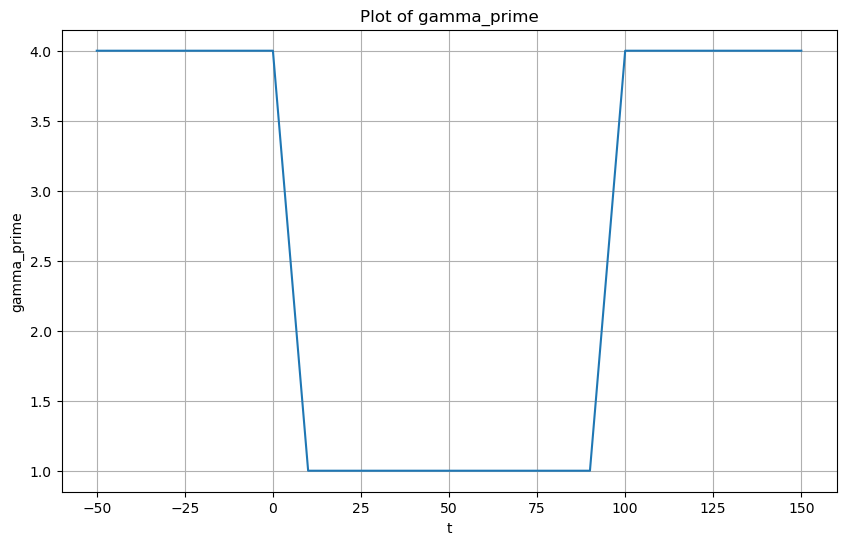

In [133]:
sample_times = np.linspace(0, 100, 11) 
ExTimes = np.concatenate(([-50], sample_times, [150]))

gamma_t = np.ones(len(ExTimes))
tv_range = max(int(round(sample_times[-1]*0.1/10)*10),1)
alpha  = np.log(4) / tv_range
for i, ti in enumerate(ExTimes): # loop over all time points, i: index, ti: time
    if ti <= 0:
        gamma_t[i] = 4
    elif ti >= sample_times[-1]:
        gamma_t[i] = 4
    elif 0 < ti and ti <= tv_range:
        gamma_t[i] = 4 * np.exp(-alpha * ti)
    elif sample_times[-1]-tv_range < ti and ti <= sample_times[-1]:
        gamma_t[i] = 1 * np.exp(alpha * (ti-sample_times[-1]+tv_range))
    else:
        gamma_t[i] = 1


plt.figure(figsize=(10, 6))
plt.plot(ExTimes, gamma_t, label="gamma_prime")
plt.title("Plot of gamma_prime")
plt.xlabel("t")
plt.ylabel("gamma_prime")
plt.grid(True)
plt.show()


In [142]:
import numpy as np
import scipy.integrate as sp


def A(x):
    return np.array([[np.sin(x), 0], [0, np.cos(x)]])

def b(x):
    return np.array([np.sin(2 * x), np.cos(2 * x)])

def fun(x, y):
    L = len(y) // 2
    s = y[:L, :]
    v = y[L:, :]
    dydx = np.zeros_like(y)

    dydx[:L, :] = v  # s'(x) = v(x)
    for i, xi in enumerate(x):
        dydx[L:, i] = A(xi) @ s[:, i] + b(xi)  # v'(x) = A(x)s(x) + b(x)

    return dydx

# def bc(ya, yb):
#     L = len(ya) // 2
#     cond = np.zeros(2 * L)
#     cond[:L] = ya[:L] - np.array([1, 0])  # s(0) = [1, 0]
#     cond[L:] = yb[:L] - np.array([0, 0])  # s(50) = [0, 0]
#     return cond

def bc(ya, yb):
    # Neumann boundary condition
    L = len(ya) // 2
    return np.ravel(np.array([ya[L:],yb[L:]])) # s' = 0 at the extended endpoints

# 初始时间点和猜测
x = np.array([0, 10])  # 初始点
y_guess = np.zeros((4, len(x)))  # 假设 L=2
solution = sp.solve_bvp(fun, bc, x, y_guess)
print(solution.x)

[ 0.          0.27777778  0.55555556  0.83333333  1.11111111  1.38888889
  1.66666667  1.94444444  2.22222222  2.36111111  2.5         2.77777778
  3.05555556  3.19444444  3.33333333  3.61111111  3.75        3.88888889
  4.02777778  4.16666667  4.44444444  4.58333333  4.72222222  4.86111111
  5.          5.27777778  5.55555556  5.83333333  6.11111111  6.38888889
  6.66666667  6.94444444  7.22222222  7.5         7.77777778  8.05555556
  8.33333333  8.61111111  8.88888889  9.16666667  9.44444444  9.72222222
  9.86111111 10.        ]


In [143]:
# 插值点
test_x = 0.4
s_10 = solution.sol(test_x)[:2]  # 解 s(10)
v_10 = solution.sol(test_x)[2:]  # 解 s'(10)

# 手动验证方程
A_10 = A(test_x)
b_10 = b(test_x)
v_prime_10 = A_10 @ s_10 + b_10

print(f"s(10): {s_10}")
print(f"s'(10): {v_10}")
print(f"s''(10) (from A(10) * s(10) + b(10)): {v_prime_10}")

s(10): [-0.65340606 -0.05730776]
s'(10): [0.09948078 0.31892202]
s''(10) (from A(10) * s(10) + b(10)): [0.46290779 0.64392277]


In [145]:
# 插值点
test_x = 0.40001  
v_10_01 = solution.sol(test_x)[2:]  # 解 s'(10)

# 手动验证方程
v_prime_10 = (v_10_01-v_10)/0.00001

print(f"s''(10) : {v_prime_10}")

s''(10) : [0.46308885 0.64375097]


In [194]:
const_num = 6
output = '_ll_11'
# Neumann boundary condition
f = open('%s/simple/mpl_collected%s.csv'%(SIM_DIR,output),'w')
f.write('trajectory,ns,delta_t')
for i in range(const_num):
    f.write(',sc_%d'%i)
f.write('\n')

for k in range(100):
    name = str(k)
    data_full   = np.load('%s/simple/output%s/c_%s.npz'%(SIM_DIR,output,name), allow_pickle="True")
    sc_full     = data_full['selection']
    TimeVaryingSC = [np.average(sc_full[i]) for i in range(const_num)]
    f.write('%d,1000,1'%k)
    for i in range(const_num):
        f.write(',%f'%TimeVaryingSC[i])
    f.write('\n')
f.close()

In [189]:
ratio = 0.2
alpha  = np.log(beta) / (ratio*1000)
gamma =  np.exp(alpha * 150)
print(gamma)

2.8284271247461903


In [35]:
times = [0,2,5,6,10,12,15,18,25,32,40,80,85,88,90,92,93,95,96,97,98]
# extend the time range
theta = 0.1
TLeft   = int(round(times[-1]*theta/10)*10)
TRight  = int(round(times[-1]*theta/10)*10)
ex_gap  = int(theta*20)
etleft  = np.linspace(-TLeft,-ex_gap,int(TLeft/ex_gap))
etright = np.linspace(times[-1]+ex_gap,times[-1]+TRight,int(TRight/ex_gap))
ExTimes = np.concatenate((etleft, times, etright))

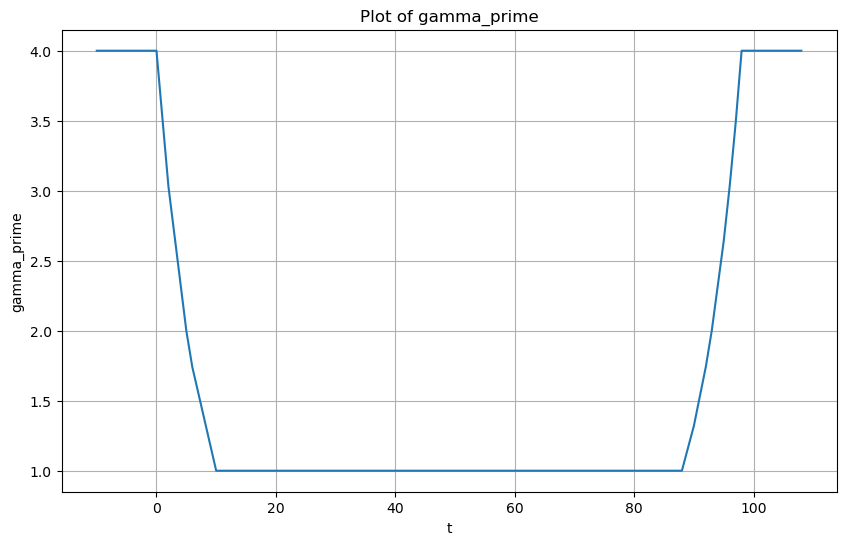

In [37]:
# regularization value gamma_1 and gamma_2

# gamma 2 is also time varying, it is larger at the boundary
gamma_t = np.zeros(len(ExTimes))
tv_range = int(round(times[-1]*0.1/10)*10)
alpha1  = np.log(4) / tv_range
alpha2  = np.log(4) / tv_range
for t in range(len(ExTimes)):
    if ExTimes[t] <= 0:
        gamma_t[t] = 4
    elif ExTimes[t] >= times[-1]:
        gamma_t[t] = 4
    elif 0 < ExTimes[t] and ExTimes[t] <= tv_range:
        gamma_t[t] = 4 * np.exp(-alpha1 * ExTimes[t])
    elif times[-1]-tv_range <= ExTimes[t] and ExTimes[t] < times[-1]:
        gamma_t[t] = 1 * np.exp(alpha2 * (ExTimes[t]-times[-1]+tv_range))
    else:
        gamma_t[t] = 1

plt.figure(figsize=(10, 6))
plt.plot(ExTimes, gamma_t, label="gamma_prime")
plt.title("Plot of gamma_prime")
plt.xlabel("t")
plt.ylabel("gamma_prime")
plt.grid(True)
plt.show()


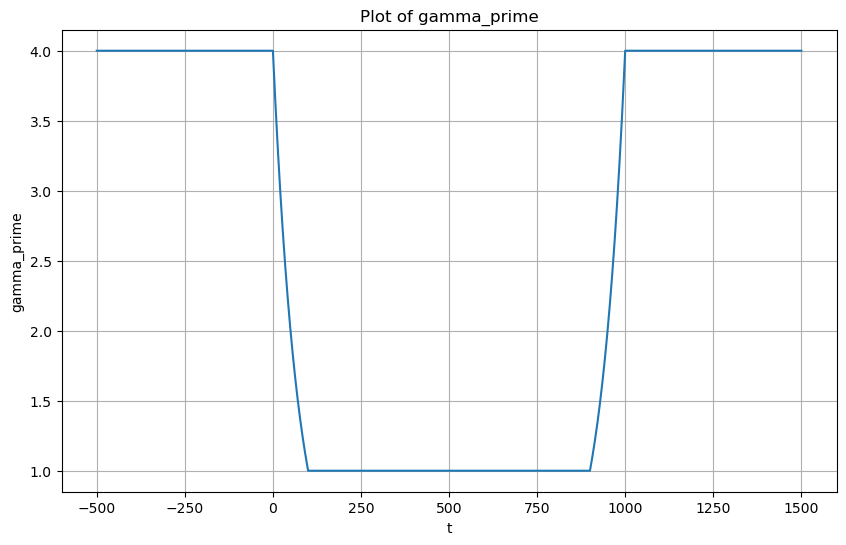

In [39]:
import numpy as np
import matplotlib.pyplot as plt

totalT = 1000
times = np.linspace(0,totalT,totalT+1)

TLeft   = int(round(times[-1]*0.5/10)*10) # time range added before the beginning time
TRight  = int(round(times[-1]*0.5/10)*10) # time range added after the ending time
etleft  = np.linspace(-TLeft,-5,int(TLeft/5)) # time added before the beginning time (dt=10)
etright = np.linspace(times[-1]+5,times[-1]+TRight,int(TRight/5))
ExTimes = np.concatenate((etleft, times, etright))


        
# 绘图
plt.figure(figsize=(10, 6))
plt.plot(ExTimes, gamma_t, label="gamma_prime")
plt.title("Plot of gamma_prime")
plt.xlabel("t")
plt.ylabel("gamma_prime")
plt.grid(True)
plt.show()

In [40]:
max(0,2)

2

In [52]:
interpolation = lambda a,b: sp_interpolate.interp1d(a,b,kind='linear')

def interpolator_x(single_freq, double_freq, current_times, result_times):
    single_freq_temp = np.zeros((len(result_times),x_length))
    double_freq_temp = np.zeros((len(result_times),x_length,x_length))

    for i in range(x_length):
        single_freq_temp[:,i] = interpolation(current_times, single_freq[:,i])(result_times)
        for j in range(x_length):
            double_freq_temp[:,i,j] = interpolation(current_times, double_freq[:,i,j])(result_times)

    return single_freq_temp, double_freq_temp

def interpolator_ex(escape_freq, current_times, result_times):
    if ne != 0:
        escape_freq_temp  = np.zeros((len(result_times),ne,seq_length,q))
    else: # if there is no escape group, return 0
        escape_freq_temp  = []

    for n in range(ne):
        for i in range(seq_length):
            for a in range(q):
                escape_freq_temp[:,n,i,a] = interpolation(current_times, escape_freq[:,n,i,a])(result_times)

    return escape_freq_temp

def interpolator_p(p_wt, p_mut_k, current_times, result_times):
    wt_temp    = np.zeros((len(result_times),ne))
    mut_k_temp = np.zeros((len(result_times),seq_length,3))
    # interpolation for wild type frequency
    for n in range(ne):
        wt_temp[:,n] = interpolation(current_times, p_wt[:,n])(result_times)

    # interpolation for frequency related to recombination part
    for i in range(seq_length):
        for j in range(3):
            mut_k_temp[:,i,j] = interpolation(current_times, p_mut_k[:,i,j])(result_times)
    
    return wt_temp, mut_k_temp

def diffusion_matrix_at_t(x,xx):
    x_length = len(x[0])
    C = np.zeros([len(x),x_length,x_length])
    for t in range(len(x)):
        for i in range(x_length):
            C[t,i,i] = x[t,i] - x[t,i] * x[t,i]
            for j in range(int(i+1) ,x_length):
                C[t,i,j] = xx[t,i,j] - x[t,i] * x[t,j]
                C[t,j,i] = xx[t,i,j] - x[t,i] * x[t,j]
    return C

def get_mutation_flux(x,ex,muVec):
    flux = np.zeros((len(x),x_length))
    for t in range(len(x)):
        for i in range(seq_length):
            for a in range(q):
                aa = int(muVec[i][a])
                if aa != -1:
                    for b in range(q):
                        bb = int(muVec[i][b])
                        if b != a:
                            if bb != -1:
                                flux[t,aa] +=  muMatrix[b][a] * x[t,bb] - muMatrix[a][b] * x[t,aa]
                            else:
                                flux[t,aa] += -muMatrix[a][b] * x[t,aa]
        for n in range(ne):
            for nn in range(len(escape_group[n])):
                for a in range(q):
                    WT = escape_TF[n][nn]
                    index = escape_group[n][nn]
                    if a not in WT:
                        for b in WT:
                            flux[t, x_length-ne+n] += muMatrix[b][a] * (1 - x[t,x_length-ne+n]) - muMatrix[a][b] * ex[t,n,index,a]
    return flux

# calculate recombination flux term
def get_recombination_flux(x,p_wt,p_mut_k,trait_dis):
    flux = np.zeros((len(x),x_length))
    for n in range(ne):
        for t in range(len(x)):
            fluxIn  = 0
            fluxOut = 0

            for nn in range(len(escape_group[n])-1):
                k_index = escape_group[n][0]+nn
                fluxIn  += trait_dis[n][nn] * p_wt[t][n]*p_mut_k[t][k_index][0]
                fluxOut += trait_dis[n][nn] * p_mut_k[t][k_index][1]*p_mut_k[t][k_index][2]

            flux[t,x_length-ne+n] = r_rate * (fluxIn - fluxOut)

    return flux

# calculate the difference between the frequency at time t and time t-1
def cal_delta_x(single_freq,times):
    delta_x = np.zeros((len(single_freq),x_length))   # difference between the frequency at time t and time t-1s
#     calculate by np.gradient function
#         for ii in range(x_length):
#             delta_x[:,ii] = np.gradient(single_freq.T[ii],times)
#     calculate manually
    for t in range(len(single_freq)-1):
        delta_x[t] = (single_freq[t+1] - single_freq[t])/(times[t+1]-times[t])

    # dt for the last time point, make sure the expected x[t+1] is less than 1
    dt_last = times[-1] - times[-2]
    for ii in range(x_length):
        if single_freq[-1,ii] + delta_x[-1,ii]*dt_last> 1:
            delta_x[-1,ii] = (1 - single_freq[-1,ii])/dt_last
        else:
            delta_x[-1,ii] = delta_x[-2,ii]

    return delta_x

In [103]:
tag = '703010131-3'
rawdata  = np.load('%s/rawdata/rawdata_%s.npz'%(HIV_DIR,tag), allow_pickle=True)
# information for individual sites
x            = rawdata['single_freq']
xx           = rawdata['double_freq']
ex           = rawdata['escape_freq']
muVec        = rawdata['muVec']
sample_times = rawdata['sample_times']
times        = rawdata['times']
time_step    = rawdata['time_step']
seq_length   = rawdata['seq_length']

# information for escape group
p_wt         = rawdata['p_wt_freq']
p_mut_k      = rawdata['p_mut_k_freq']
p_sites      = rawdata['special_sites']
escape_group = rawdata['escape_group'].tolist()
escape_TF    = rawdata['escape_TF'].tolist()
trait_dis    = rawdata['trait_dis'].tolist()

ne           = len(escape_group)
x_length     = len(x[0])
print(x_length)

217


In [104]:
print(x[:,18])

[1.         1.         1.         0.83333333 1.         1.
 1.         1.         1.        ]


In [56]:
NUC = ['-', 'A', 'C', 'G', 'T']
q = len(NUC)
muMatrix = np.loadtxt("%s/Zanini-extended.dat"%HIV_DIR)

# after interpolation, calculate all the required data
single_freq, double_freq = interpolator_x(x, xx, sample_times, times)
escape_freq              = interpolator_ex(ex, sample_times, times)
p_wt_freq, p_mut_k_freq  = interpolator_p(p_wt, p_mut_k,sample_times, times)

In [58]:
r_rate = 1.4e-5
# covariance matrix, flux term and delta_x
covariance_n = diffusion_matrix_at_t(single_freq, double_freq)
covariance   = np.swapaxes(covariance_n, 0, 2)
flux_mu      = get_mutation_flux(single_freq,escape_freq,muVec)         # mutation part
flux_rec     = get_recombination_flux(single_freq,p_wt_freq,p_mut_k_freq,trait_dis) # recombination part
delta_x      = cal_delta_x(single_freq,times)

# extend the time range
TLeft   = int(round(times[-1]*theta/10)*10)
TRight  = int(round(times[-1]*theta/10)*10)
ex_gap  = int(theta*20)
etleft  = np.linspace(-TLeft,-ex_gap,int(TLeft/ex_gap))
etright = np.linspace(times[-1]+ex_gap,times[-1]+TRight,int(TRight/ex_gap))
ExTimes = np.concatenate((etleft, times, etright))

In [61]:
# regularization value gamma_1 and gamma_2
# individual site: gamma_1s, escape group: gamma_1p
gamma_1s = round(10/sample_times[-1],3) # constant MPL gamma value / max time
gamma_1p = gamma_1s/10
gamma1   = np.ones(x_length)*gamma_1s
for n in range(ne):
    gamma1[x_length-ne+n] = gamma_1p

# gamma 2 is also time varying, it is larger at the boundary
gamma_t = np.zeros(len(ExTimes))
tv_range = max(int(round(times[-1]*0.1/10)*10),1)
alpha1  = np.log(4) / tv_range
alpha2  = np.log(4) / tv_range
for t in range(len(ExTimes)):
    if ExTimes[t] <= 0:
        gamma_t[t] = 4
    elif ExTimes[t] >= times[-1]:
        gamma_t[t] = 4
    elif 0 < ExTimes[t] and ExTimes[t] <= tv_range:
        gamma_t[t] = 4 * np.exp(-alpha1 * ExTimes[t])
    elif times[-1]-tv_range <= ExTimes[t] and ExTimes[t] < times[-1]:
        gamma_t[t] = 1 * np.exp(alpha2 * (ExTimes[t]-times[-1]+tv_range))
    else:
        gamma_t[t] = 1

gamma_2c = 200
gamma_2tv = 1000000
# individual site: gamma_2c, escape group and special site: gamma_2tv
gamma2 = np.ones((x_length,len(ExTimes)))*gamma_2c
for n in range(ne):
    gamma2[x_length-ne+n] = gamma_t * gamma_2tv
for p_site in p_sites: # special site - time varying
    for qq in range(len(NUC)):
        index = int (muVec[p_site][qq]) 
        if index != -1:
            gamma2[index] = gamma_t * gamma_2tv


In [66]:
# solve the bounadry condition ODE to infer selections
def fun(a,b):
    """ Function defining the right-hand side of the system of ODE's"""
    b_1                 = b[:x_length,:]   # the actual selection coefficients
    b_2                 = b[x_length:,:]   # the derivatives of the selection coefficients, s'
    result              = np.zeros((2*x_length,len(a))) # The RHS of the system of ODE's
    result[:x_length]   = b_2       # sets the derivatives of the selection coefficients 'b_1', equal to s'
    mat_prod            = np.sum(covariance[:,:,:len(a)] * b_1[:,len(etleft):len(etleft)+len(times)], 1)

    for t in range(len(a)): # right hand side of second half of the ODE system
        # within the time range
        if len(etleft) <= t < len(etleft)+len(times):
            tt = t - len(etleft)
            for i in range(x_length):
                result[x_length+i,t] = (mat_prod[i,tt] + gamma1[i] * b_1[i,t] + flux_mu[tt,i] + flux_rec[tt,i] - delta_x[tt,i]) / gamma2[i,t]

        # outside the time range, no selection strength
        else:
            for i in range(x_length):
                result[x_length+i,t] = gamma1[i] * b_1[i,t] / gamma2[i,t]

    return result

def bc(b1,b2):
    return np.ravel(np.array([b1[x_length:],b2[x_length:]])) # s' = 0 at the extended endpoints

ss_extend = np.zeros((2*x_length,len(ExTimes)))

solution = sp.integrate.solve_bvp(fun, bc, ExTimes, ss_extend, max_nodes=10000, tol=1e-3)

selection_coefficients = solution.sol(ExTimes)
# removes the superfluous part of the array and only save the real time points
desired_coefficients   = selection_coefficients[:x_length,len(etleft):len(etleft)+len(times)]



In [79]:
print(times)
print(x[:,-3])

[  0   5  10  15  21  28  34  39  44  49  54  59  63  68  73  78  83  88
  91  96 101 106 111 116 121 126 131 136 141 146 151 156 161 166 171 175
 180 185 190 195 200 205 210 215 220 225 230 235 240 245 250 255 260 265
 270 273 278 283 288 293 298 303 308 313 318 323 328 333]
[0.03030303 0.         0.         0.         0.         0.
 0.         0.         0.        ]


In [70]:
print(len(desired_coefficients[-1]))

68


In [64]:
print(times)

[  0   5  10  15  21  28  34  39  44  49  54  59  63  68  73  78  83  88
  91  96 101 106 111 116 121 126 131 136 141 146 151 156 161 166 171 175
 180 185 190 195 200 205 210 215 220 225 230 235 240 245 250 255 260 265
 270 273 278 283 288 293 298 303 308 313 318 323 328 333]


In [42]:
importlib.reload(sim)

# Load the simulation data
data         = np.loadtxt("%s/example/example-0.dat"%(SIM_DIR))
escape_group = sim.read_file('example','traitsite-0.dat')
trait_dis    = sim.read_file('example','traitsite-0.dat')

p_sites      = [13,18]
# Calculate covariance matrix
sVec,nVec,eVec = sim.getSequence(data,escape_group)
seq_length     = len(sVec[0][0])      # sequence length
ne             = len(escape_group) # trait group

muVec    = -np.ones(seq_length)
x_length = 0
for i in range(seq_length):
    allele_count = np.zeros(len(sVec))
    allele_count = [np.sum([(sVec[t][k][i]==1)*nVec[t][k] for k in range(len(sVec[t]))]) for t in range(len(sVec))]
    if max(allele_count) / np.sum(nVec[0]) >= 0:
        muVec[i] = x_length
        x_length += 1
x_length      += ne


In [60]:
def get_allele_frequency(sVec,nVec,eVec,muVec):

    x  = np.zeros((len(nVec),x_length))           # single allele frequency
    xx = np.zeros((len(nVec),x_length,x_length))  # pair allele frequency
    for t in range(len(nVec)):
        pop_size_t = np.sum([nVec[t]])
        # individual locus part
        for i in range(seq_length):
            aa = int(muVec[i])
            if aa != -1:
                x[t,aa] = np.sum([sVec[t][k][i] * nVec[t][k] for k in range(len(sVec[t]))]) / pop_size_t
            for j in range(int(i+1), seq_length):
                bb = int(muVec[j])
                if bb != -1:
                    xx[t,aa,bb] = np.sum([sVec[t][k][i] * sVec[t][k][j] * nVec[t][k] for k in range(len(sVec[t]))]) / pop_size_t
                    xx[t,aa,bb] = np.sum([sVec[t][k][i] * sVec[t][k][j] * nVec[t][k] for k in range(len(sVec[t]))]) / pop_size_t
        # escape part
        for n in range(ne):
            aa      = x_length-ne+n
            x[t,aa] = np.sum([eVec[t][k][n] * nVec[t][k] for k in range(len(sVec[t]))]) / pop_size_t
            for m in range(int(n+1), ne):
                bb          = x_length-ne+m
                xx[t,aa,bb] = np.sum([eVec[t][k][n] * eVec[t][k][m] * nVec[t][k] for k in range(len(sVec[t]))]) / pop_size_t
                xx[t,bb,aa] = np.sum([eVec[t][k][n] * eVec[t][k][m] * nVec[t][k] for k in range(len(sVec[t]))]) / pop_size_t
            for j in range(seq_length):
                bb = int(muVec[j])
                if bb != -1:
                    xx[t,bb,aa] = np.sum([sVec[t][k][j] * eVec[t][k][n] * nVec[t][k] for k in range(len(sVec[t]))]) / pop_size_t
                    xx[t,aa,bb] = np.sum([sVec[t][k][j] * eVec[t][k][n] * nVec[t][k] for k in range(len(sVec[t]))]) / pop_size_t
    return x,xx

# calculate escape frequency (binary case)
def get_escape_fre_term(sVec,nVec):
    ex  = np.zeros((len(nVec),ne,seq_length))
    for t in range(len(nVec)):
        pop_size_t = np.sum([nVec[t]])
        for k in range(len(sVec[t])):
            for n in range(ne):
                n_mutations = 0
                for nn in escape_group[n]:
                    if sVec[t][k][nn] != 0:
                        n_mutations += 1
                        site = nn
                if n_mutations == 1:
                    ex[t,n,site] += nVec[t][k]
        ex[t,:,:] = ex[t,:,:] / pop_size_t
    return ex

x,xx         = get_allele_frequency(sVec,nVec,eVec,muVec) 
covar_int    = sim.diffusion_matrix_at_t(x,xx,x_length)


In [79]:
gamma_1s      = 10/500 # gamma_s/time points
gamma_1p      = gamma_1s/10
gamma_2c      = 1000000       # 1000000
gamma_2tv     = 500

# regularization value gamma_1 and gamma_2
# individual site: gamma_1s, escape group: gamma_1p
gamma1_m = np.zeros((x_length,x_length))
for i in range(x_length):
    gamma1_m[i][i] = gamma_1s
for n in range(ne):
    nn = x_length-ne+n
    gamma1_m[nn][nn] = gamma_1p

# individual site: gamma_2c, escape group and special site: gamma_2tv
gamma2 = np.ones(x_length)*gamma_2c
for n in range(ne):
    gamma2[x_length-ne+n] = gamma_2tv
for i in range(len(p_sites)): # special site - time varying
    index = int (muVec[p_sites[i]]) 
    if index != -1:
        gamma2[index] = gamma_2tv

A_matrix = np.zeros((x_length,x_length))
for i in range(x_length):
    for j in range(x_length):
        A_matrix[i][j] = (np.average(covar_int[:,i,j])+gamma1_m[i,j])/gamma2[i]

print(A_matrix[0,0])

1.6262595409181634e-07


In [46]:
d_value, Q_matrix = np.linalg.eig(A_matrix) # calculate the eigenvalues d_value and eigenvectors Q_matrix
D_matrix = np.diag(d_value) # D is a diagonal matrix with the eigenvalues of A


In [4]:
tag = '703010131-3'
rawdata = np.load('%s/rawdata/rawdata_%s.npz'%(HIV_DIR,tag), allow_pickle="True")
x            = rawdata['single_freq']
print(len(x[0]))

241


In [25]:
def getSequence(history,escape_TF,escape_group):
    sVec      = []
    nVec      = []
    eVec      = []

    temp_sVec   = []
    temp_nVec   = []
    temp_eVec   = []

    times       = []
    time        = 0
    times.append(time)

    ne          = len(escape_group)

    for t in range(len(history)):
        if history[t][0] != time:
            time = history[t][0]
            times.append(int(time))
            sVec.append(temp_sVec)
            nVec.append(temp_nVec)
            eVec.append(temp_eVec)
            temp_sVec   = []
            temp_nVec   = []
            temp_eVec   = []

        temp_nVec.append(history[t][1])
        temp_sVec.append(history[t][2:])

        if ne > 0: # the patient contains escape group
            temp_escape = np.zeros(ne, dtype=int)
            for n in range(ne):
                for nn in range(len(escape_group[n])):
                    index = escape_group[n][nn] + 2
                    if history[t][index] not in escape_TF[n][nn]:
                        temp_escape[n] = 1
                        break
            temp_eVec.append(temp_escape)

        if t == len(history)-1:
            sVec.append(temp_sVec)
            nVec.append(temp_nVec)
            eVec.append(temp_eVec)

    return sVec,nVec,eVec

# get muVec
def getMutantS(sVec):
    # use muVec matrix to record the index of time-varying sites
    muVec = -np.ones((seq_length, q)) # default value is -1, positive number means the index
    x_length  = 0

    for i in range(seq_length):            
        # find all possible alleles in site i
        alleles     = [int(sVec[t][k][i]) for t in range(len(sVec)) for k in range(len(sVec[t]))]
        allele_uniq = np.unique(alleles)
        for allele in allele_uniq:
            muVec[i][int(allele)] = x_length
            x_length += 1

    return x_length,muVec

In [29]:
import inference_HIV as HIV
importlib.reload(HIV)

infer_tags = ['700010040-3','700010040-5','700010058-3','700010058-5','700010077-3','700010077-5',
              '700010470-3','700010470-5','700010607-3','703010131-3','703010131-5','703010159-3',
              '703010256-3','703010256-5','704010042-3','704010042-5','705010162-3','705010162-5',
              '705010185-5','705010198-3','706010164-3','706010164-5']

tag = '703010131-3'
data     = np.loadtxt('%s/sequence/%s-poly-seq2state.dat'%(HIV_DIR,tag))

# data     = np.loadtxt('%s/sequence/%s-cut.dat'%(HIV_DIR,tag))

# information for escape group
result       = HIV.AnalyzeData(tag,HIV_DIR)
escape_group = result.escape_group
escape_TF    = result.escape_TF
trait_dis    = result.trait_dis
seq_length   = result.seq_length
sample_times = result.uniq_t
times        = result.IntTime
ne           = len(escape_group)

## regularization parameter
p_sites      = result.special_sites
time_step    = result.time_step
q = 5

print(escape_TF)
print(seq_length)
# obtain sequence data and frequencies
sVec,nVec,eVec = getSequence(data,escape_TF,escape_group)
# x_length,muVec = getMutantS(sVec)


[[[4], [2], [4], [2]], [[3], [1], [1], [1], [1], [1, 3], [1], [1], [3], [1], [1], [1], [1]]]
107


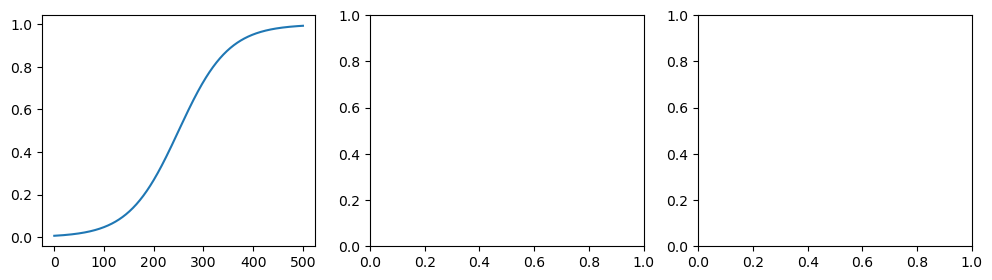

In [86]:
t_x  = np.linspace(0, 500, 501)
x_mu = np.exp(s_coef * (t_x-250)) / (np.exp(s_coef * (t_x-250)) + 1)

times  = np.linspace(0,int(t_x[-1]),int(t_x[-1]+1))


fig, axs = plt.subplots(1, 3, figsize=(12, 3))

axs[0].plot(t_x,x_mu)




In order to convert the genotype level to allele level, we begin by defining G as a M$\times$(L+$\Lambda$)

In [79]:
import sys,os
import argparse
from typing import List
import numpy as np
import scipy as sp
import pandas as pd
from scipy import integrate
import scipy.interpolate as sp_interpolate
import statistics
import pickle
from dataclasses import dataclass
import time as time_module
from itertools import product

## nucleotide parameter
NUC = ['-', 'A', 'C', 'G', 'T']
q = len(NUC)

@dataclass
class Result:
    variants: int
    seq_length: int
    special_sites: List[int]
    uniq_t: List[int]
    r_rates: List[float]
    time_step: int
    escape_group: List[List[int]]
    escape_TF: List[List[int]]
    trait_dis: List[List[int]]
    IntTime: List[int]

In [80]:
def AnalyzeData(tag,HIV_DIR):
    if tag == '704010042-3' or tag == '703010131-3':
        df_info = pd.read_csv('%s/constant/analysis/%s-analyze-cut.csv' %(HIV_DIR,tag), comment='#', memory_map=True)
        seq     = np.loadtxt('%s/sequence/%s-cut.dat'%(HIV_DIR,tag))
    else:
        df_info = pd.read_csv('%s/constant/analysis/%s-analyze.csv' %(HIV_DIR,tag), comment='#', memory_map=True)
        seq     = np.loadtxt('%s/sequence/%s-poly-seq2state.dat'%(HIV_DIR,tag))

    """get raw time points"""
    times = []
    for i in range(len(seq)):
        times.append(seq[i][0])
    uniq_t = np.unique(times)

    '''get recombinant rate'''
    r_rates = np.loadtxt('%s/r_rates/r-%s.dat'%(HIV_DIR, tag))
    if len(r_rates) != len(uniq_t):
        print('Error: the length of r_rates is not equal to the length of time')
        sys.exit

    """get variants number and sequence length"""
    df_poly  = df_info[df_info['nucleotide']!=df_info['TF']]
    variants = len(df_poly)
    seq_length = int(df_info.iloc[-1].polymorphic_index + 1)

    """get special sites and escape sites"""
    # get all epitopes for one tag
    df_rows = df_info[df_info['epitope'].notna()]
    unique_epitopes = df_rows['epitope'].unique()

    min_n = 2 # the least escape sites a trait group should have (more than min_n)
    special_sites = [] # special site considered as time-varying site but not escape site
    escape_group  = [] # escape group (each group should have more than 2 escape sites)
    escape_TF     = [] # corresponding wild type nucleotide
    for epi in unique_epitopes:
        df_e = df_rows[(df_rows['epitope'] == epi) & (df_rows['escape'] == True)] # find all escape mutation for one epitope
        unique_sites = df_e['polymorphic_index'].unique()
        unique_sites = [int(site) for site in unique_sites]

        if len(unique_sites) <= min_n:
            special_sites.append(unique_sites)
        else:
            escape_group.append(list(unique_sites))
            escape_TF_epi = []
            for site in unique_sites:
                tf_values = []
                df_site = df_info[df_info['polymorphic_index'] == site]
                for i in range(len(df_site)):
                    if df_site.iloc[i].escape != True:
                        tf_values.append(int(NUC.index(df_site.iloc[i].nucleotide)))
                escape_TF_epi.append(tf_values)
            escape_TF.append(escape_TF_epi)

    special_sites = [item for sublist in special_sites for item in sublist]

    """trait distance"""
    trait_dis = []
    if len(escape_group) > 0:
        for i in range(len(escape_group)):
            i_dis = []
            for j in range(len(escape_group[i])-1):
                index0 = df_info[df_info['polymorphic_index']==escape_group[i][j]].iloc[0].alignment
                index1 = df_info[df_info['polymorphic_index']==escape_group[i][j+1]].iloc[0].alignment
                i_dis.append(int(index1-index0))
            trait_dis.append(i_dis)

    """find proper time step"""
    if uniq_t[-1] < 100:
        time_step = 1
    else:
        if seq_length > 300:
            time_step = 20
        elif seq_length < 100:
            time_step = 1
        else:
            time_step = 5

    """find proper gamma value"""
    # interpolation time according to the time step get above, all the inserted time points are integer
    times = [0]
    for t in range(1,len(uniq_t)):
        tp_i   = round((uniq_t[t]-uniq_t[t-1])/time_step) # number of insertion points
        if tp_i > 0:
            ts_i   = round((uniq_t[t]-uniq_t[t-1])/tp_i) # modified time step
            for i in range(tp_i):
                time_i = uniq_t[t-1] + (i+1) * ts_i
                time_s = uniq_t[t]
                # if the inserted time is close to the bounadry time point, throw out the inserted point
                if abs(time_i-time_s) <= ts_i/2:
                    times.append(int(time_s))
                else:
                    times.append(int(time_i))
        else:
            times.append(uniq_t[t])
    IntTime = list(times)

    return Result(variants, seq_length, special_sites, uniq_t, r_rates, time_step, escape_group, escape_TF, trait_dis, IntTime)


In [83]:
tag = '700010040-3'
HIV_DIR = 'data/HIV'
rawdata  = np.load('%s/rawdata/rawdata_%s.npz'%(HIV_DIR,tag), allow_pickle=True)
# information for individual sites
x            = rawdata['single_freq']
xx           = rawdata['double_freq']
ex           = rawdata['escape_freq']
muVec        = rawdata['muVec']
sample_times = rawdata['sample_times']
r_rates      = rawdata['r_rates']
times        = rawdata['times']
time_step    = rawdata['time_step']
seq_length   = rawdata['seq_length']

# information for escape group
p_wt         = rawdata['p_wt_freq']
p_mut_k      = rawdata['p_mut_k_freq']
p_sites      = rawdata['special_sites']
escape_group = rawdata['escape_group'].tolist()
escape_TF    = rawdata['escape_TF'].tolist()
trait_dis    = rawdata['trait_dis'].tolist()


In [112]:
print(x[2][:10])
print(x[3][:10])
print(sample_times)

[1. 0. 1. 0. 0. 1. 1. 0. 0. 1.]
[0.88888889 0.11111111 1.         0.         0.         1.
 1.         0.         0.         1.        ]
[  0.  16.  45. 111. 181. 283. 412. 552.]


In [113]:
def cal_delta_x(single_freq,times):
    delta_x = np.zeros((len(single_freq),x_length))   # difference between the frequency at time t and time t-1s
#     calculate manually
    for t in range(len(single_freq)-1):
        delta_x[t] = (single_freq[t+1] - single_freq[t])/(times[t+1]-times[t])

    # dt for the last time point, make sure the expected x[t+1] is less than 1
    dt_last = times[-1] - times[-2]
    for ii in range(x_length):
        if single_freq[-1,ii] + delta_x[-1,ii]*dt_last> 1:
            delta_x[-1,ii] = (1 - single_freq[-1,ii])/dt_last
        else:
            delta_x[-1,ii] = delta_x[-2,ii]
    return delta_x

dx = cal_delta_x(x,sample_times)
print(dx[0][:10])
print(dx[1][:10])
print(dx[2][:10])
print(dx[3][:10])


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[-0.0016835  0.0016835  0.         0.         0.         0.
  0.         0.         0.         0.       ]
[ 0.0015873 -0.0015873  0.         0.         0.         0.
  0.         0.         0.         0.       ]


In [110]:
print(x[2][:10])
print(x[3][:10])
print(times[3]-times[2])

[1. 0. 1. 0. 0. 1. 1. 0. 0. 1.]
[0.88888889 0.11111111 1.         0.         0.         1.
 1.         0.         0.         1.        ]
22


In [98]:
print(flux_rec[1])

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.         

In [75]:
for i in range(seq_length):
    if (x[0][i] != 0) & (x[0][i] != 1):
        print(i)

59
60
113
114


In [50]:
print(ex[0][2][288][1],end='\t')

0.25	

In [25]:
for i in range(10):
    for j in range(10):
        print(xx[0][i][j], end='\t')
    print('')

0.0	0.0	1.0	0.0	0.0	1.0	1.0	0.0	0.0	1.0	
0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	
1.0	0.0	0.0	0.0	0.0	1.0	1.0	0.0	0.0	1.0	
0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	
0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	
1.0	0.0	1.0	0.0	0.0	0.0	1.0	0.0	0.0	1.0	
1.0	0.0	1.0	0.0	0.0	1.0	0.0	0.0	0.0	1.0	
0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	
0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	
1.0	0.0	1.0	0.0	0.0	1.0	1.0	0.0	0.0	0.0	


In [9]:
print(len(escape_group))

3


In [42]:
int(round(500*0.1/10)*10)

50

In [5]:
## nucleotide parameter
NUC = ['-', 'A', 'C', 'G', 'T']
q = len(NUC)

In [8]:
# Interpolation function definition
# Interpolates the input arrays so that they will have the same number of generations as the original population.
interpolation = lambda a,b: sp_interpolate.interp1d(a,b,kind='linear')

def interpolator_x(single_freq, double_freq, current_times, result_times):
    single_freq_temp = np.zeros((len(result_times),x_length))
    double_freq_temp = np.zeros((len(result_times),x_length,x_length))
    
    for i in range(x_length):
        single_freq_temp[:,i] = interpolation(current_times, single_freq[:,i])(result_times)
        for j in range(x_length):
            double_freq_temp[:,i,j] = interpolation(current_times, double_freq[:,i,j])(result_times)
    
    return single_freq_temp, double_freq_temp

def interpolator_ex(escape_freq, current_times, result_times):
    if ne != 0:
        escape_freq_temp  = np.zeros((len(result_times),ne,seq_length,q))
    else: # if there is no escape group, return 0
        escape_freq_temp  = []
    
    for n in range(ne):
        for i in range(seq_length):
            for a in range(q):
                escape_freq_temp[:,n,i,a] = interpolation(current_times, escape_freq[:,n,i,a])(result_times)
    
    return escape_freq_temp

def interpolator_p(p_wt, p_mut_k, current_times, result_times):
    wt_temp    = np.zeros((len(result_times),ne))
    mut_k_temp = np.zeros((len(result_times),seq_length,3))
    # interpolation for wild type frequency
    for n in range(ne):
        wt_temp[:,n] = interpolation(current_times, p_wt[:,n])(result_times)

    # interpolation for frequency related to recombination part
    for i in range(seq_length):
        for j in range(3):
            mut_k_temp[:,i,j] = interpolation(current_times, p_mut_k[:,i,j])(result_times)

    wt_temp    = wt_temp[:len(result_times)]
    mut_k_temp = mut_k_temp[:len(result_times)]

    return wt_temp, mut_k_temp

def get_mutation_flux(x,ex,muVec):
    flux = np.zeros((len(x),x_length))
    for t in range(len(x)):
        for i in range(seq_length):
            for a in range(q):
                aa = int(muVec[i][a])
                if aa != -1:
                    for b in range(q):
                        bb = int(muVec[i][b])
                        if b != a:
                            if bb != -1:
                                flux[t,aa] +=  muMatrix[b][a] * x[t,bb] - muMatrix[a][b] * x[t,aa]
                            else:
                                flux[t,aa] += -muMatrix[a][b] * x[t,aa]
        for n in range(ne):
            for nn in range(len(escape_group[n])):
                for a in range(q):
                    WT = escape_TF[n][nn]
                    index = escape_group[n][nn]
                    if a not in WT:
                        for b in WT:
                            flux[t, x_length-ne+n] += muMatrix[b][a] * (1 - x[t,x_length-ne+n]) - muMatrix[a][b] * ex[t,n,index,a]
    return flux
# calculate recombination flux term
def get_recombination_flux(x, r_rates, p_wt, p_mut_k, trait_dis):
    flux = np.zeros((len(x),x_length))
    for n in range(ne):
        for t in range(len(x)):
            fluxIn  = 0
            fluxOut = 0

            for nn in range(len(escape_group[n])-1):
                k_index = escape_group[n][0]+nn
                fluxIn  += trait_dis[n][nn] * p_wt[t][n]*p_mut_k[t][k_index][0]
                fluxOut += trait_dis[n][nn] * p_mut_k[t][k_index][1]*p_mut_k[t][k_index][2]
            
            flux[t,x_length-ne+n] = r_rates[t] * (fluxIn - fluxOut)

    return flux

# calculate the difference between the frequency at time t and time t-1
def cal_delta_x(single_freq,times):
    delta_x = np.zeros((len(single_freq),x_length))   # difference between the frequency at time t and time t-1s
#     calculate by np.gradient function
#         for ii in range(x_length):
#             delta_x[:,ii] = np.gradient(single_freq.T[ii],times)
#     calculate manually
    for t in range(len(single_freq)-1):
        delta_x[t] = (single_freq[t+1] - single_freq[t])/(times[t+1]-times[t])

    # dt for the last time point, make sure the expected x[t+1] is less than 1
    dt_last = times[-1] - times[-2]
    for ii in range(x_length):
        if single_freq[-1,ii] + delta_x[-1,ii]*dt_last> 1:
            delta_x[-1,ii] = (1 - single_freq[-1,ii])/dt_last
        else:
            delta_x[-1,ii] = delta_x[-2,ii]

    return delta_x

In [62]:
tag = '700010040-5'

rawdata  = np.load('%s/rawdata/rawdata_%s.npz'%(HIV_DIR,tag), allow_pickle=True)
# information for individual sites
x            = rawdata['single_freq']
xx           = rawdata['double_freq']
ex           = rawdata['escape_freq']
muVec        = rawdata['muVec']
sample_times = rawdata['sample_times']
times        = rawdata['times']
time_step    = rawdata['time_step']
seq_length   = rawdata['seq_length']
r_rates = rawdata['r_rates']

# information for escape group
p_wt         = rawdata['p_wt_freq']
p_mut_k      = rawdata['p_mut_k_freq']
p_sites      = rawdata['special_sites']
escape_group = rawdata['escape_group'].tolist()
escape_TF    = rawdata['escape_TF'].tolist()
trait_dis    = rawdata['trait_dis'].tolist()

ne           = len(escape_group)
x_length     = len(x[0])

muMatrix = np.loadtxt("%s/Zanini-extended.dat"%HIV_DIR)

In [63]:
import json

escape_group = np.array(escape_group).tolist()
escape_TF = np.array(escape_TF).tolist()
trait_dis = np.array(trait_dis).tolist()
r_rates = np.array(r_rates).tolist()
p_sites = np.array(p_sites).tolist()

data = {
    'escape_group': escape_group,
    'escape_TF': escape_TF,
    'trait_dis': trait_dis,
    'r_rates': r_rates,
    'p_sites':p_sites
}

# 将字典写入到 .json 文件中
with open('combined_data.json', 'w') as f:
    json.dump(data, f)

# 读取数据
with open('combined_data.json', 'r') as f:
    data = json.load(f)

# 访问其中的数据
a_data = data['escape_group']
b_data = data['escape_TF']
c_data = data['trait_dis']
d_data = data['r_rates']

In [48]:
single_freq, double_freq = interpolator_x(x, xx, sample_times, times)
escape_freq              = interpolator_ex(ex, sample_times, times)
p_wt_freq, p_mut_k_freq  = interpolator_p(p_wt, p_mut_k,sample_times, times)
r_rates_times            = interpolation(sample_times, r_rates)(times)

# covariance matrix, flux term and delta_x
flux_mu      = get_mutation_flux(single_freq,escape_freq,muVec)         # mutation part
flux_rec     = get_recombination_flux(single_freq,r_rates_times, p_wt_freq,p_mut_k_freq,trait_dis) # recombination part
delta_x      = cal_delta_x(single_freq,times)

In [49]:
source = (delta_x + flux_rec + flux_mu).T

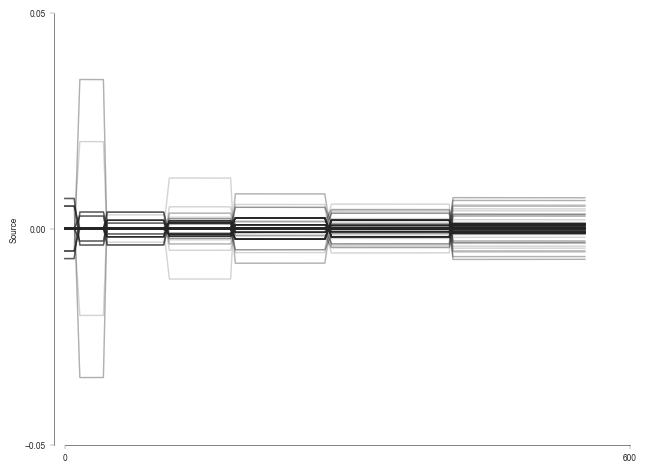

In [50]:
import mplot as mp
BKCOLOR  = '#252525'

box = dict(left=0.08, right=0.98, bottom=0.08, top=0.98)
gs  = gridspec.GridSpec(1, 1, width_ratios=[1.0], height_ratios=[1.0], **box)
ax  = plt.subplot(gs[0, 0])

pprops = { 'xticks':      [0, 600],
           'yticks':      [-0.05, 0, 0.05],
           'nudgey':      1,
           'xlabel':      '',
           'ylabel':      'Source',
           'plotprops':   {'lw': 1, 'ls': '-', 'alpha': 0.2 },
           'axoffset':    0.1,
           'theme':       'open'}

xdat = [times for k in range(len(source))]
ydat = source
mp.plot(type='line',ax=ax, x=xdat, y=ydat, colors=[BKCOLOR for k in range(len(source))], **pprops)

# mp.plot(type='line',ax=ax, x=[times], y=[source_avg], colors=[BKCOLOR], **pprops)


In [54]:
infer_tags = ['700010040-3','700010040-5','700010058-3','700010058-5','700010077-3','700010077-5',
              '700010470-3','700010470-5','700010607-3','703010131-3','703010131-5','703010159-3',
              '703010256-3','703010256-5','704010042-3','704010042-5','705010162-3','705010162-5',
              '705010185-5','705010198-3','706010164-3','706010164-5']

for tag in infer_tags:
    
    rawdata  = np.load('%s/rawdata/rawdata_%s.npz'%(HIV_DIR,tag), allow_pickle=True)
    p_sites      = rawdata['special_sites']
    
    f = open("%s/input/spsite/sp-%s.dat"%(HIV_DIR,tag),'w')
    f.write('%s' % ('\t'.join(str(int(p_site)) for p_site in p_sites)))
    f.close()